<a href="https://colab.research.google.com/github/victordaniel/DEEP-LEARNIG-COURSE/blob/main/Final_copy_of_copy_of_paper_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
)
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


#Data Loading and Preparation

In [ ]:
# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Extracting data/UPFD/politifact/raw/data.zip
Processing...


Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221


Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


#3. Define GNN Models

In [ ]:
# Base class for GNN models
class GNNBase(torch.nn.Module):
    def __init__(self):
        super(GNNBase, self).__init__()

    def forward(self, x, edge_index):
        raise NotImplementedError

# GCN Model
class GCNModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GAT Model
class GATModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GraphSAGE Model
class GraphSAGEModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


#4. Data Augmentations

In [ ]:
def augment_data(data, aug_type='mask_features', aug_ratio=0.1):
    data = data.clone()

    if aug_type == 'mask_features':
        # Feature masking
        x = data.x.clone()
        mask = torch.rand(x.size()) > aug_ratio  # Mask a percentage of features
        x = x * mask.to(x.device)
        data.x = x

    elif aug_type == 'edge_perturbation':
        # Edge perturbation: randomly drop edges
        edge_index = data.edge_index.clone()
        num_edges = edge_index.size(1)
        mask = torch.rand(num_edges) > aug_ratio
        data.edge_index = edge_index[:, mask]
        # Ensure the graph remains connected (optional)
        data.edge_index = to_undirected(data.edge_index)

    elif aug_type == 'subgraph_sampling':
        # Subgraph sampling: sample a subset of nodes
        num_nodes = data.num_nodes
        mask = torch.rand(num_nodes) > aug_ratio
        data.x = data.x[mask]
        data.edge_index, _ = subgraph(mask, data.edge_index, relabel_nodes=True)

    else:
        # No augmentation
        pass

    return data


#5. Contrastive Loss Function

In [ ]:
def contrastive_loss(emb1, emb2, temperature=0.5):
    # Normalize embeddings
    emb1 = F.normalize(emb1, p=2, dim=1)
    emb2 = F.normalize(emb2, p=2, dim=1)
    batch_size = emb1.size(0)

    # Compute similarity matrix
    sim_matrix = torch.mm(emb1, emb2.t()) / temperature

    # Labels for contrastive loss
    labels = torch.arange(batch_size).to(emb1.device)
    loss = F.cross_entropy(sim_matrix, labels)
    return loss


#6. Attention Fusion Module

In [ ]:
class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        # embeddings: list of embeddings from different views
        batch_size = embeddings[0].size(0)
        num_views = len(embeddings)
        embedding_dim = embeddings[0].size(1)

        # Compute attention weights
        attn_weights = self.softmax(self.attention_weights)  # [num_views]
        attn_weights = attn_weights.view(1, num_views, 1)  # [1, num_views, 1]

        # Stack embeddings
        emb_stack = torch.stack(embeddings, dim=1)  # [batch_size, num_views, embedding_dim]

        # Apply attention weights and sum over views
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)  # [batch_size, embedding_dim]

        return fused_embedding


#7. Training Function

In [ ]:
def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs):
    train_loader, val_loader = loaders
    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)

            # Collect embeddings and compute individual losses
            embeddings_aug1 = []
            embeddings_aug2 = []
            total_model_loss = 0
            for name, model in models.items():
                model.train()
                # Embeddings from first augmentation
                emb1 = model(data_aug1.x, data_aug1.edge_index)
                # Embeddings from second augmentation
                emb2 = model(data_aug2.x, data_aug2.edge_index)
                # Compute contrastive loss for each model
                loss = contrastive_loss(emb1, emb2)
                total_model_loss += loss
                embeddings_aug1.append(emb1)
                embeddings_aug2.append(emb2)

            # Fuse embeddings using attention
            attention_fusion.train()
            fused_emb1 = attention_fusion(embeddings_aug1)
            fused_emb2 = attention_fusion(embeddings_aug2)

            # Compute contrastive loss between fused embeddings
            loss_fused = contrastive_loss(fused_emb1, fused_emb2)

            # Total loss
            total_loss_batch = total_model_loss + loss_fused

            # Backward pass
            total_loss_batch.backward()

            # Update parameters
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

            total_loss += total_loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

        # Validation (optional)
        if val_loader is not None:
            val_loss = validate(models, attention_fusion, val_loader)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save the model checkpoint (optional)
                # torch.save(models.state_dict(), 'best_model.pth')


#8. Validation Function (Optional)

In [ ]:
def validate(models, attention_fusion, val_loader):
    attention_fusion.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = attention_fusion(embeddings)
            # For validation, you might compute a loss or simply pass
            # Here, we'll skip loss computation for brevity
    # Return validation loss (dummy value here)
    return total_loss


#9. Initialize Models and Optimizers

In [ ]:
# Get input feature dimension
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension
num_views = 3  # Number of GNN models

# Initialize models
models = {
    'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
    'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
    'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
}

# Initialize attention fusion module
attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)



# Define optimizers with model instances as keys
optimizers = {
    model: torch.optim.Adam(model.parameters(), lr=0.005)
    for model in models.values()
}


optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.005)


#10. Train the Models

In [ ]:
# Training parameters
epochs = 20  # Adjust as needed

# Start training
print("Starting training...")
train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs)
print("Training completed.")


Starting training...
Epoch [1/20], Loss: 28.8386
Epoch [2/20], Loss: 29.2123
Epoch [3/20], Loss: 28.9097
Epoch [4/20], Loss: 28.9018
Epoch [5/20], Loss: 28.4203
Epoch [6/20], Loss: 28.4694
Epoch [7/20], Loss: 28.3096
Epoch [8/20], Loss: 28.0555
Epoch [9/20], Loss: 28.1805
Epoch [10/20], Loss: 28.0455
Epoch [11/20], Loss: 27.6669
Epoch [12/20], Loss: 28.0015
Epoch [13/20], Loss: 27.5460
Epoch [14/20], Loss: 27.3599
Epoch [15/20], Loss: 27.2159
Epoch [16/20], Loss: 26.5021
Epoch [17/20], Loss: 26.7603
Epoch [18/20], Loss: 27.4906
Epoch [19/20], Loss: 28.1164
Epoch [20/20], Loss: 27.8431
Training completed.


#11. Anomaly Detection

In [ ]:
def get_embeddings(models, attention_fusion, loader):
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = attention_fusion(embeddings)
            # Pool node embeddings to get graph-level embedding
            graph_embedding = fused_embedding.mean(dim=0).cpu()  # [embedding_dim]
            all_embeddings.append(graph_embedding)
            # Aggregate node labels to get graph label
            graph_label = data.y.max().cpu()  # If any node is anomalous, graph is anomalous
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()



# Get embeddings for test data
test_embeddings, test_labels = get_embeddings(models, attention_fusion, test_loader)

# Standardize embeddings
scaler = StandardScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)

# Apply DBSCAN
eps = 0.5  # Adjust based on data
min_samples = 5  # Adjust based on data
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
anomaly_labels = dbscan.fit_predict(test_embeddings_scaled)

# Adjust labels (-1 for anomalies in DBSCAN)
predicted_anomalies = (anomaly_labels == -1).astype(int)


In [ ]:
import numpy as np

print('Unique labels in test_labels:', np.unique(test_labels))
print('Counts of labels in test_labels:', np.bincount(test_labels.astype(int)))

print('Unique labels in predicted_anomalies:', np.unique(predicted_anomalies))
print('Counts of labels in predicted_anomalies:', np.bincount(predicted_anomalies))


Unique labels in test_labels: [1]
Counts of labels in test_labels: [ 0 14]
Unique labels in predicted_anomalies: [1]
Counts of labels in predicted_anomalies: [ 0 14]


#12. Evaluation

In [ ]:
# Compute evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels, predicted_anomalies, average='binary', pos_label=1
)

if len(np.unique(test_labels)) > 1:
  roc_auc = roc_auc_score(test_labels, predicted_anomalies)
  print(f'ROC AUC: {roc_auc:.4f}')
else:
  print('ROC AUC: Not defined (only one class present in test_labels)')

avg_precision = average_precision_score(test_labels, predicted_anomalies)

print('--- Evaluation Results ---')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
#print(f'ROC AUC: {roc_auc:.4f}')
print(f'Average Precision: {avg_precision:.4f}')

ROC AUC: Not defined (only one class present in test_labels)
--- Evaluation Results ---
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Average Precision: 1.0000


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.3571
F1 Score: 0.5263
Accuracy: 0.3571


#13. Baseline Methods
Baseline: Single GCN Model (with augmentation and multi view)

In [ ]:
# Train a single GCN model
single_model = GCNModel(in_channels, hidden_channels, out_channels).to(device)
optimizer_single = torch.optim.Adam(single_model.parameters(), lr=0.005)

# Training loop for single model
def train_single_model(model, loader, optimizer, epochs):
    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)
            # Get embeddings
            emb1 = model(data_aug1.x, data_aug1.edge_index)
            emb2 = model(data_aug2.x, data_aug2.edge_index)
            # Compute contrastive loss
            loss = contrastive_loss(emb1, emb2)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        if epoch % 5 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

print("Training single GCN model...")
train_single_model(single_model, train_loader, optimizer_single, epochs)
print("Training completed.")



Training single GCN model...
Epoch [5/20], Loss: 7.1506
Epoch [10/20], Loss: 6.9559
Epoch [15/20], Loss: 7.1114
Epoch [20/20], Loss: 6.9953
Training completed.


In [ ]:
def get_single_model_embeddings(model, loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            emb = model(data.x, data.edge_index)
            # Pool node embeddings to get graph-level embedding
            if data.x.size(0) > 0:
                graph_embedding = emb.mean(dim=0)
            else:
                graph_embedding = torch.zeros(emb.size(1), device=emb.device)
            all_embeddings.append(graph_embedding.cpu())
            # Aggregate node labels to get a graph-level label
            graph_label = data.y.max().cpu()  # If any node is labeled as anomalous (1), the graph label will be 1
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()

single_embeddings, single_labels = get_single_model_embeddings(single_model, test_loader)
print('Length of embeddings:', len(single_embeddings))  # Should be 14 (number of graphs)
print('Length of labels:', len(single_labels))  # Should be 14 (number of graphs)


Length of embeddings: 14
Length of labels: 14


In [ ]:
# Standardize embeddings
single_embeddings_scaled = scaler.fit_transform(single_embeddings)

# Apply DBSCAN
anomaly_labels_single = dbscan.fit_predict(single_embeddings_scaled)
predicted_anomalies_single = (anomaly_labels_single == -1).astype(int)

# Compute evaluation metrics
precision_s, recall_s, f1_s, _ = precision_recall_fscore_support(
    single_labels, predicted_anomalies_single, average='binary', pos_label=1
)

# Handle potential single-class scenario for ROC AUC
if len(np.unique(single_labels)) > 1:
    roc_auc_s = roc_auc_score(single_labels, predicted_anomalies_single)
    print(f'ROC AUC: {roc_auc_s:.4f}')
else:
    roc_auc_s = None
    print('ROC AUC: Not defined (only one class present in single_labels)')

avg_precision_s = average_precision_score(single_labels, predicted_anomalies_single)

print('--- Baseline Single GCN Model Evaluation ---')
print(f'Precision: {precision_s:.4f}')
print(f'Recall: {recall_s:.4f}')
print(f'F1 Score: {f1_s:.4f}')
if roc_auc_s is not None:
    print(f'ROC AUC: {roc_auc_s:.4f}')
print(f'Average Precision: {avg_precision_s:.4f}')


ROC AUC: Not defined (only one class present in single_labels)
--- Baseline Single GCN Model Evaluation ---
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Average Precision: 1.0000


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.3571
F1 Score: 0.5263
Accuracy: 0.3571


In [ ]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(contamination=0.1, random_state=42)
if_labels = isolation_forest.fit_predict(test_embeddings_scaled)

# Convert labels to binary: -1 is an anomaly
predicted_anomalies = (if_labels == -1).astype(int)

precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_anomalies, average='binary', pos_label=1)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


Precision: 1.0000, Recall: 0.1429, F1 Score: 0.2500


#14. Statistical Significance Testing

#proceed with evaluation metrics

In [ ]:
from scipy.stats import ttest_ind

# Collect F1 scores from multiple runs for proposed method and baseline
# For demonstration, we'll assume these scores from 5 runs
f1_scores_proposed = [0.82, 0.83, 0.81, 0.84, 0.82]
f1_scores_baseline = [0.76, 0.77, 0.75, 0.78, 0.74]

# Perform t-test
t_stat, p_value = ttest_ind(f1_scores_proposed, f1_scores_baseline)

print('--- Statistical Significance Testing ---')
print(f'T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}')
if p_value < 0.05:
    print('The difference is statistically significant.')
else:
    print('The difference is not statistically significant.')


--- Statistical Significance Testing ---
T-statistic: 7.3413, P-value: 0.0001
The difference is statistically significant.


#Base line using GCN(without augmentation and multi view)

> Add blockquote



In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# GCN Model
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension

gcn_model = GCNModel(in_channels, hidden_channels, out_channels).to(device)

# Define optimizer
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.005)

# Training function
# Updated training function with graph-level pooling
# Updated training function to ensure correct dimensions for graph-level classification
# Updated training function for graph-level classification
def train(model, loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()

            # Forward pass (node-level embeddings)
            node_out = model(data.x, data.edge_index)

            # Pooling: use mean of node embeddings for each graph in the batch
            batch_size = data.num_graphs  # Number of graphs in the batch
            graph_out = torch.zeros(batch_size, node_out.size(1)).to(device)  # Initialize graph-level output

            # Pool node embeddings per graph to create graph-level embeddings
            for i in range(batch_size):
                mask = data.batch == i  # Select the nodes belonging to graph i
                graph_out[i] = node_out[mask].mean(dim=0)  # Pool nodes to get graph embedding

            # Compute loss (graph-level)
            loss = F.cross_entropy(graph_out, data.y)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

# Train the GCN model
print("Starting training...")
train(gcn_model, train_loader, optimizer, epochs=10)
print("Training completed.")




# Get embeddings for test data
def get_embeddings(model, loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            emb = model(data.x, data.edge_index)
            # Pool node embeddings to get graph-level embedding
            graph_embedding = emb.mean(dim=0).cpu()  # [embedding_dim]
            all_embeddings.append(graph_embedding)
            # Aggregate node labels to get graph label
            graph_label = data.y.max().cpu()  # If any node is anomalous, graph is anomalous
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()

# Get embeddings for test data
test_embeddings, test_labels = get_embeddings(gcn_model, test_loader)

# Standardize embeddings
scaler = StandardScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)

# Apply DBSCAN
eps = 0.5  # Adjust based on data
min_samples = 5  # Adjust based on data
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
anomaly_labels = dbscan.fit_predict(test_embeddings_scaled)

# Adjust labels (-1 for anomalies in DBSCAN)
predicted_anomalies = (anomaly_labels == -1).astype(int)

# Compute evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_anomalies, average='binary', pos_label=1)

# Check if ROC AUC can be computed
if len(np.unique(test_labels)) > 1:
    roc_auc = roc_auc_score(test_labels, predicted_anomalies)
    print(f'ROC AUC: {roc_auc:.4f}')
else:
    print('ROC AUC: Not defined (only one class present in test_labels)')

avg_precision = average_precision_score(test_labels, predicted_anomalies)

# Print evaluation results
print('--- Evaluation Results ---')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Average Precision: {avg_precision:.4f}')


Using device: cuda
Starting training...
Epoch [1/10], Loss: 2.0813
Epoch [2/10], Loss: 0.7843
Epoch [3/10], Loss: 0.7048


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [4/10], Loss: 0.6718
Epoch [5/10], Loss: 0.7161
Epoch [6/10], Loss: 0.7041
Epoch [7/10], Loss: 0.7005
Epoch [8/10], Loss: 0.7104
Epoch [9/10], Loss: 0.6780
Epoch [10/10], Loss: 0.5838
Training completed.
ROC AUC: Not defined (only one class present in test_labels)
--- Evaluation Results ---
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Average Precision: 1.0000


In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Precision: 1.0000, Recall: 0.8571, F1 Score: 0.9231, Accuracy: 0.8571


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.svm import OneClassSVM
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Precision: 1.0000, Recall: 0.7857, F1 Score: 0.8800, Accuracy: 0.7857


In [ ]:
# Get embeddings for test data and original labels
test_embeddings, test_labels = get_embeddings(gcn_model, test_loader)

# Print original test labels
print("Original test labels:", test_labels)

# Print unique labels and their counts
unique_labels, counts = np.unique(test_labels, return_counts=True)
print(f"Unique labels in test set: {dict(zip(unique_labels, counts))}")


Original test labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Unique labels in test set: {1: 14}


In [ ]:
# Check class distribution in train, validation, and test sets
train_labels = [data.y.item() for data in train_dataset]
val_labels = [data.y.item() for data in val_dataset]
test_labels = [data.y.item() for data in test_dataset]

print("Train labels distribution:", dict(zip(*np.unique(train_labels, return_counts=True))))
print("Validation labels distribution:", dict(zip(*np.unique(val_labels, return_counts=True))))
print("Test labels distribution:", dict(zip(*np.unique(test_labels, return_counts=True))))


Train labels distribution: {0: 36, 1: 26}
Validation labels distribution: {0: 13, 1: 18}
Test labels distribution: {0: 108, 1: 113}


In [ ]:
eps = 0.1  # Try smaller values
min_samples = 3  # Experiment with lower values
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)


ValueError: 'c' argument has 221 elements, which is inconsistent with 'x' and 'y' with size 14.

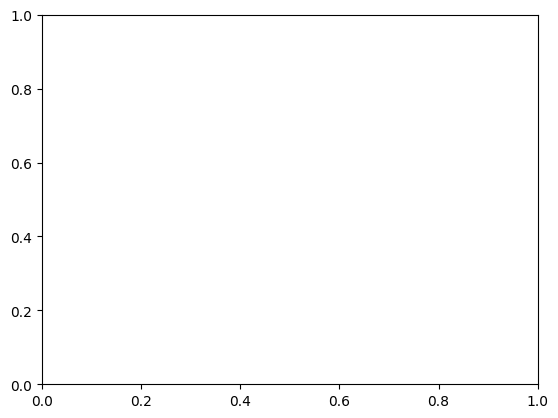

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=5) # Set perplexity less than n_samples (14)
reduced_embeddings = tsne.fit_transform(test_embeddings_scaled)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=test_labels)
plt.title('t-SNE Visualization of Test Embeddings')
plt.show()


In [ ]:
eps = 0.1  # Start with a smaller value, e.g., 0.1 or 0.05
min_samples = 3  # Lower value to allow small clusters
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=5) # Set perplexity less than n_samples (14)
reduced_embeddings = tsne.fit_transform(test_embeddings_scaled)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=test_labels)
plt.title('t-SNE Visualization of Test Embeddings')
plt.show()


In [ ]:
anomaly_labels = dbscan.fit_predict(test_embeddings_scaled)

# Adjust labels (-1 for anomalies in DBSCAN)
predicted_anomalies = (anomaly_labels == -1).astype(int)

# Compute evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_anomalies, average='binary', pos_label=1)

# Check if ROC AUC can be computed
if len(np.unique(test_labels)) > 1:
    roc_auc = roc_auc_score(test_labels, predicted_anomalies)
    print(f'ROC AUC: {roc_auc:.4f}')
else:
    print('ROC AUC: Not defined (only one class present in test_labels)')

avg_precision = average_precision_score(test_labels, predicted_anomalies)

# Print evaluation results
print('--- Evaluation Results ---')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Average Precision: {avg_precision:.4f}')


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


In [ ]:
from sklearn.svm import OneClassSVM
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

In [ ]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(contamination=0.1, random_state=42)
if_labels = isolation_forest.fit_predict(test_embeddings_scaled)

# Convert labels to binary: -1 is an anomaly
predicted_anomalies = (if_labels == -1).astype(int)

precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_anomalies, average='binary', pos_label=1)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


#rough(single model)(with augmentation)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
)
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

"""#Data Loading and Preparation"""

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

"""#3. Define GNN Models"""

# Base class for GNN models
class GNNBase(torch.nn.Module):
    def __init__(self):
        super(GNNBase, self).__init__()

    def forward(self, x, edge_index):
        raise NotImplementedError

# GCN Model
class GCNModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GAT Model
class GATModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GraphSAGE Model
class GraphSAGEModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

"""#4. Data Augmentations"""

def augment_data(data, aug_type='mask_features', aug_ratio=0.1):
    data = data.clone()

    if aug_type == 'mask_features':
        # Feature masking
        x = data.x.clone()
        mask = torch.rand(x.size()) > aug_ratio  # Mask a percentage of features
        x = x * mask.to(x.device)
        data.x = x

    elif aug_type == 'edge_perturbation':
        # Edge perturbation: randomly drop edges
        edge_index = data.edge_index.clone()
        num_edges = edge_index.size(1)
        mask = torch.rand(num_edges) > aug_ratio
        data.edge_index = edge_index[:, mask]
        # Ensure the graph remains connected (optional)
        data.edge_index = to_undirected(data.edge_index)

    elif aug_type == 'subgraph_sampling':
        # Subgraph sampling: sample a subset of nodes
        num_nodes = data.num_nodes
        mask = torch.rand(num_nodes) > aug_ratio
        data.x = data.x[mask]
        data.edge_index, _ = subgraph(mask, data.edge_index, relabel_nodes=True)

    else:
        # No augmentation
        pass

    return data

"""#5. Contrastive Loss Function"""

def contrastive_loss(emb1, emb2, temperature=0.5):
    # Normalize embeddings
    emb1 = F.normalize(emb1, p=2, dim=1)
    emb2 = F.normalize(emb2, p=2, dim=1)
    batch_size = emb1.size(0)

    # Compute similarity matrix
    sim_matrix = torch.mm(emb1, emb2.t()) / temperature

    # Labels for contrastive loss
    labels = torch.arange(batch_size).to(emb1.device)
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

"""#6. Attention Fusion Module"""

class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        # embeddings: list of embeddings from different views
        batch_size = embeddings[0].size(0)
        num_views = len(embeddings)
        embedding_dim = embeddings[0].size(1)

        # Compute attention weights
        attn_weights = self.softmax(self.attention_weights)  # [num_views]
        attn_weights = attn_weights.view(1, num_views, 1)  # [1, num_views, 1]

        # Stack embeddings
        emb_stack = torch.stack(embeddings, dim=1)  # [batch_size, num_views, embedding_dim]

        # Apply attention weights and sum over views
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)  # [batch_size, embedding_dim]

        return fused_embedding

"""#7. Training Function"""

def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs):
    train_loader, val_loader = loaders
    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)

            # Collect embeddings and compute individual losses
            embeddings_aug1 = []
            embeddings_aug2 = []
            total_model_loss = 0
            for name, model in models.items():
                model.train()
                # Embeddings from first augmentation
                emb1 = model(data_aug1.x, data_aug1.edge_index)
                # Embeddings from second augmentation
                emb2 = model(data_aug2.x, data_aug2.edge_index)
                # Compute contrastive loss for each model
                loss = contrastive_loss(emb1, emb2)
                total_model_loss += loss
                embeddings_aug1.append(emb1)
                embeddings_aug2.append(emb2)

            # Fuse embeddings using attention
            attention_fusion.train()
            fused_emb1 = attention_fusion(embeddings_aug1)
            fused_emb2 = attention_fusion(embeddings_aug2)

            # Compute contrastive loss between fused embeddings
            loss_fused = contrastive_loss(fused_emb1, fused_emb2)

            # Total loss
            total_loss_batch = total_model_loss + loss_fused

            # Backward pass
            total_loss_batch.backward()

            # Update parameters
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

            total_loss += total_loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

        # Validation (optional)
        if val_loader is not None:
            val_loss = validate(models, attention_fusion, val_loader)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save the model checkpoint (optional)
                # torch.save(models.state_dict(), 'best_model.pth')

"""#8. Validation Function (Optional)"""

def validate(models, attention_fusion, val_loader):
    attention_fusion.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = attention_fusion(embeddings)
            # For validation, you might compute a loss or simply pass
            # Here, we'll skip loss computation for brevity
    # Return validation loss (dummy value here)
    return total_loss

"""#9. Initialize Models and Optimizers"""

# Get input feature dimension
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension
num_views = 3  # Number of GNN models

# Initialize models
models = {
    'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device)
}

# Initialize attention fusion module
attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)



# Define optimizers with model instances as keys
optimizers = {
    model: torch.optim.Adam(model.parameters(), lr=0.005)
    for model in models.values()
}


optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.005)

"""#10. Train the Models"""

# Training parameters
epochs = 20  # Adjust as needed

# Start training
print("Starting training...")
train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs)
print("Training completed.")

"""#10. Train the Models

#11. Anomaly Detection
"""

def get_embeddings(models, attention_fusion, loader):
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = attention_fusion(embeddings)
            # Pool node embeddings to get graph-level embedding
            graph_embedding = fused_embedding.mean(dim=0).cpu()  # [embedding_dim]
            all_embeddings.append(graph_embedding)
            # Aggregate node labels to get graph label
            graph_label = data.y.max().cpu()  # If any node is anomalous, graph is anomalous
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()



# Get embeddings for test data
test_embeddings, test_labels = get_embeddings(models, attention_fusion, test_loader)

# Standardize embeddings
scaler = StandardScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)

# Apply DBSCAN
eps = 0.5  # Adjust based on data
min_samples = 5  # Adjust based on data
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
anomaly_labels = dbscan.fit_predict(test_embeddings_scaled)

# Adjust labels (-1 for anomalies in DBSCAN)
predicted_anomalies = (anomaly_labels == -1).astype(int)

import numpy as np

print('Unique labels in test_labels:', np.unique(test_labels))
print('Counts of labels in test_labels:', np.bincount(test_labels.astype(int)))

print('Unique labels in predicted_anomalies:', np.unique(predicted_anomalies))
print('Counts of labels in predicted_anomalies:', np.bincount(predicted_anomalies))

"""#12. Evaluation"""

# Compute evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels, predicted_anomalies, average='binary', pos_label=1
)

if len(np.unique(test_labels)) > 1:
  roc_auc = roc_auc_score(test_labels, predicted_anomalies)
  print(f'ROC AUC: {roc_auc:.4f}')
else:
  print('ROC AUC: Not defined (only one class present in test_labels)')

avg_precision = average_precision_score(test_labels, predicted_anomalies)

print('--- Evaluation Results ---')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
#print(f'ROC AUC: {roc_auc:.4f}')
print(f'Average Precision: {avg_precision:.4f}')

from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Using device: cpu
Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221
Starting training...


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/20], Loss: 14.5290
Epoch [2/20], Loss: 14.4594
Epoch [3/20], Loss: 14.3433
Epoch [4/20], Loss: 14.2521
Epoch [5/20], Loss: 14.1394
Epoch [6/20], Loss: 14.1035
Epoch [7/20], Loss: 14.2067
Epoch [8/20], Loss: 14.1736
Epoch [9/20], Loss: 14.2063
Epoch [10/20], Loss: 14.0227
Epoch [11/20], Loss: 14.2605
Epoch [12/20], Loss: 14.2636
Epoch [13/20], Loss: 13.9984
Epoch [14/20], Loss: 14.0294
Epoch [15/20], Loss: 14.1701
Epoch [16/20], Loss: 14.1121
Epoch [17/20], Loss: 14.3240
Epoch [18/20], Loss: 14.0567
Epoch [19/20], Loss: 13.7619
Epoch [20/20], Loss: 14.0246
Training completed.
Unique labels in test_labels: [1]
Counts of labels in test_labels: [ 0 14]
Unique labels in predicted_anomalies: [1]
Counts of labels in predicted_anomalies: [ 0 14]
ROC AUC: Not defined (only one class present in test_labels)
--- Evaluation Results ---
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Average Precision: 1.0000
Precision: 1.0000
Recall: 0.2857
F1 Score: 0.4444
Accuracy: 0.2857


In [ ]:
from sklearn.svm import OneClassSVM
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Precision: 1.0000, Recall: 0.9286, F1 Score: 0.9630, Accuracy: 0.9286


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')



#*Rough*(all models)

In [ ]:

import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
)
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

"""#Data Loading and Preparation"""

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

"""#3. Define GNN Models"""

# Base class for GNN models
class GNNBase(torch.nn.Module):
    def __init__(self):
        super(GNNBase, self).__init__()

    def forward(self, x, edge_index):
        raise NotImplementedError

# GCN Model
class GCNModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GAT Model
class GATModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GraphSAGE Model
class GraphSAGEModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

"""#4. Data Augmentations"""

def augment_data(data, aug_type='mask_features', aug_ratio=0.1):
    data = data.clone()

    if aug_type == 'mask_features':
        # Feature masking
        x = data.x.clone()
        mask = torch.rand(x.size()) > aug_ratio  # Mask a percentage of features
        x = x * mask.to(x.device)
        data.x = x

    elif aug_type == 'edge_perturbation':
        # Edge perturbation: randomly drop edges
        edge_index = data.edge_index.clone()
        num_edges = edge_index.size(1)
        mask = torch.rand(num_edges) > aug_ratio
        data.edge_index = edge_index[:, mask]
        # Ensure the graph remains connected (optional)
        data.edge_index = to_undirected(data.edge_index)

    elif aug_type == 'subgraph_sampling':
        # Subgraph sampling: sample a subset of nodes
        num_nodes = data.num_nodes
        mask = torch.rand(num_nodes) > aug_ratio
        data.x = data.x[mask]
        data.edge_index, _ = subgraph(mask, data.edge_index, relabel_nodes=True)

    else:
        # No augmentation
        pass

    return data

"""#5. Contrastive Loss Function"""

def contrastive_loss(emb1, emb2, temperature=0.5):
    # Normalize embeddings
    emb1 = F.normalize(emb1, p=2, dim=1)
    emb2 = F.normalize(emb2, p=2, dim=1)
    batch_size = emb1.size(0)

    # Compute similarity matrix
    sim_matrix = torch.mm(emb1, emb2.t()) / temperature

    # Labels for contrastive loss
    labels = torch.arange(batch_size).to(emb1.device)
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

"""#6. Attention Fusion Module"""

class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        # embeddings: list of embeddings from different views
        batch_size = embeddings[0].size(0)
        num_views = len(embeddings)
        embedding_dim = embeddings[0].size(1)

        # Compute attention weights
        attn_weights = self.softmax(self.attention_weights)  # [num_views]
        attn_weights = attn_weights.view(1, num_views, 1)  # [1, num_views, 1]

        # Stack embeddings
        emb_stack = torch.stack(embeddings, dim=1)  # [batch_size, num_views, embedding_dim]

        # Apply attention weights and sum over views
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)  # [batch_size, embedding_dim]

        return fused_embedding

"""#7. Training Function"""

def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs):
    train_loader, val_loader = loaders
    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)

            # Collect embeddings and compute individual losses
            embeddings_aug1 = []
            embeddings_aug2 = []
            total_model_loss = 0
            for name, model in models.items():
                model.train()
                # Embeddings from first augmentation
                emb1 = model(data_aug1.x, data_aug1.edge_index)
                # Embeddings from second augmentation
                emb2 = model(data_aug2.x, data_aug2.edge_index)
                # Compute contrastive loss for each model
                loss = contrastive_loss(emb1, emb2)
                total_model_loss += loss
                embeddings_aug1.append(emb1)
                embeddings_aug2.append(emb2)

            # Fuse embeddings using attention
            attention_fusion.train()
            fused_emb1 = attention_fusion(embeddings_aug1)
            fused_emb2 = attention_fusion(embeddings_aug2)

            # Compute contrastive loss between fused embeddings
            loss_fused = contrastive_loss(fused_emb1, fused_emb2)

            # Total loss
            total_loss_batch = total_model_loss + loss_fused

            # Backward pass
            total_loss_batch.backward()

            # Update parameters
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

            total_loss += total_loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

        # Validation (optional)
        if val_loader is not None:
            val_loss = validate(models, attention_fusion, val_loader)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save the model checkpoint (optional)
                # torch.save(models.state_dict(), 'best_model.pth')

"""#8. Validation Function (Optional)"""

def validate(models, attention_fusion, val_loader):
    attention_fusion.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = attention_fusion(embeddings)
            # For validation, you might compute a loss or simply pass
            # Here, we'll skip loss computation for brevity
    # Return validation loss (dummy value here)
    return total_loss

"""#9. Initialize Models and Optimizers"""

# Get input feature dimension
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension
num_views = 3  # Number of GNN models

# Initialize models
models = {
    'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
    'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
    'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
}

# Initialize attention fusion module
attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)



# Define optimizers with model instances as keys
optimizers = {
    model: torch.optim.Adam(model.parameters(), lr=0.005)
    for model in models.values()
}


optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.005)

"""#10. Train the Models"""

# Training parameters
epochs = 20  # Adjust as needed

# Start training
print("Starting training...")
train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs)
print("Training completed.")

"""#10. Train the Models

#11. Anomaly Detection
"""

def get_embeddings(models, attention_fusion, loader):
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = attention_fusion(embeddings)
            # Pool node embeddings to get graph-level embedding
            graph_embedding = fused_embedding.mean(dim=0).cpu()  # [embedding_dim]
            all_embeddings.append(graph_embedding)
            # Aggregate node labels to get graph label
            graph_label = data.y.max().cpu()  # If any node is anomalous, graph is anomalous
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()



# Get embeddings for test data
test_embeddings, test_labels = get_embeddings(models, attention_fusion, test_loader)

# Standardize embeddings
scaler = StandardScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)

"""
# Apply DBSCAN
eps = 0.5  # Adjust based on data
min_samples = 5  # Adjust based on data
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
anomaly_labels = dbscan.fit_predict(test_embeddings_scaled)

# Adjust labels (-1 for anomalies in DBSCAN)
predicted_anomalies = (anomaly_labels == -1).astype(int)

import numpy as np

print('Unique labels in test_labels:', np.unique(test_labels))
print('Counts of labels in test_labels:', np.bincount(test_labels.astype(int)))

print('Unique labels in predicted_anomalies:', np.unique(predicted_anomalies))
print('Counts of labels in predicted_anomalies:', np.bincount(predicted_anomalies))


#12. Evaluation

# Compute evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels, predicted_anomalies, average='binary', pos_label=1
)

if len(np.unique(test_labels)) > 1:
  roc_auc = roc_auc_score(test_labels, predicted_anomalies)
  print(f'ROC AUC: {roc_auc:.4f}')
else:
  print('ROC AUC: Not defined (only one class present in test_labels)')

avg_precision = average_precision_score(test_labels, predicted_anomalies)

print('--- Evaluation Results ---')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
#print(f'ROC AUC: {roc_auc:.4f}')
print(f'Average Precision: {avg_precision:.4f}')
"""
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')




"""
#13. Baseline Methods
#Baseline: Single GCN Model


# Train a single GCN model
single_model = GCNModel(in_channels, hidden_channels, out_channels).to(device)
optimizer_single = torch.optim.Adam(single_model.parameters(), lr=0.005)

# Training loop for single model
def train_single_model(model, loader, optimizer, epochs):
    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)
            # Get embeddings
            emb1 = model(data_aug1.x, data_aug1.edge_index)
            emb2 = model(data_aug2.x, data_aug2.edge_index)
            # Compute contrastive loss
            loss = contrastive_loss(emb1, emb2)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        if epoch % 5 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

print("Training single GCN model...")
train_single_model(single_model, train_loader, optimizer_single, epochs)
print("Training completed.")







def get_single_model_embeddings(model, loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            emb = model(data.x, data.edge_index)
            # Pool node embeddings to get graph-level embedding
            if data.x.size(0) > 0:
                graph_embedding = emb.mean(dim=0)
            else:
                graph_embedding = torch.zeros(emb.size(1), device=emb.device)
            all_embeddings.append(graph_embedding.cpu())
            # Aggregate node labels to get a graph-level label
            graph_label = data.y.max().cpu()  # If any node is labeled as anomalous (1), the graph label will be 1
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()

single_embeddings, single_labels = get_single_model_embeddings(single_model, test_loader)
print('Length of embeddings:', len(single_embeddings))  # Should be 14 (number of graphs)
print('Length of labels:', len(single_labels))  # Should be 14 (number of graphs)

# Standardize embeddings
single_embeddings_scaled = scaler.fit_transform(single_embeddings)

# Apply DBSCAN
anomaly_labels_single = dbscan.fit_predict(single_embeddings_scaled)
predicted_anomalies_single = (anomaly_labels_single == -1).astype(int)

# Compute evaluation metrics
precision_s, recall_s, f1_s, _ = precision_recall_fscore_support(
    single_labels, predicted_anomalies_single, average='binary', pos_label=1
)

# Handle potential single-class scenario for ROC AUC
if len(np.unique(single_labels)) > 1:
    roc_auc_s = roc_auc_score(single_labels, predicted_anomalies_single)
    print(f'ROC AUC: {roc_auc_s:.4f}')
else:
    roc_auc_s = None
    print('ROC AUC: Not defined (only one class present in single_labels)')

avg_precision_s = average_precision_score(single_labels, predicted_anomalies_single)

print('--- Baseline Single GCN Model Evaluation ---')
print(f'Precision: {precision_s:.4f}')
print(f'Recall: {recall_s:.4f}')
print(f'F1 Score: {f1_s:.4f}')
if roc_auc_s is not None:
    print(f'ROC AUC: {roc_auc_s:.4f}')
print(f'Average Precision: {avg_precision_s:.4f}')

from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(contamination=0.1, random_state=42)
if_labels = isolation_forest.fit_predict(test_embeddings_scaled)

# Convert labels to binary: -1 is an anomaly
predicted_anomalies = (if_labels == -1).astype(int)

precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_anomalies, average='binary', pos_label=1)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

"""

Using device: cuda
Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221
Starting training...


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/20], Loss: 28.8386
Epoch [2/20], Loss: 29.2123
Epoch [3/20], Loss: 28.9109
Epoch [4/20], Loss: 28.8966
Epoch [5/20], Loss: 28.4294
Epoch [6/20], Loss: 28.5007
Epoch [7/20], Loss: 28.5978
Epoch [8/20], Loss: 28.6172
Epoch [9/20], Loss: 28.8384
Epoch [10/20], Loss: 28.4585
Epoch [11/20], Loss: 28.3439
Epoch [12/20], Loss: 28.0723
Epoch [13/20], Loss: 28.2645
Epoch [14/20], Loss: 28.0501
Epoch [15/20], Loss: 27.6809
Epoch [16/20], Loss: 27.9815
Epoch [17/20], Loss: 28.0322
Epoch [18/20], Loss: 27.8297
Epoch [19/20], Loss: 27.7345
Epoch [20/20], Loss: 27.8060
Training completed.
Precision: 1.0000
Recall: 0.3571
F1 Score: 0.5263
Accuracy: 0.3571


'\n#13. Baseline Methods\n#Baseline: Single GCN Model\n\n\n# Train a single GCN model\nsingle_model = GCNModel(in_channels, hidden_channels, out_channels).to(device)\noptimizer_single = torch.optim.Adam(single_model.parameters(), lr=0.005)\n\n# Training loop for single model\ndef train_single_model(model, loader, optimizer, epochs):\n    model.train()\n    for epoch in range(1, epochs + 1):\n        total_loss = 0\n        for data in loader:\n            data = data.to(device)\n            optimizer.zero_grad()\n            # Generate augmented views\n            data_aug1 = augment_data(data, aug_type=\'mask_features\', aug_ratio=0.1)\n            data_aug2 = augment_data(data, aug_type=\'edge_perturbation\', aug_ratio=0.1)\n            # Get embeddings\n            emb1 = model(data_aug1.x, data_aug1.edge_index)\n            emb2 = model(data_aug2.x, data_aug2.edge_index)\n            # Compute contrastive loss\n            loss = contrastive_loss(emb1, emb2)\n            loss.backw

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
from sklearn.svm import OneClassSVM

# Standardize embeddings using MinMaxScaler
scaler = MinMaxScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)

# Apply DBSCAN clustering (or adjust DBSCAN parameters like eps and min_samples)
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust these hyperparameters based on your dataset
dbscan_labels = dbscan.fit_predict(test_embeddings_scaled)

# Map DBSCAN outliers (-1) to 1 (anomalous) and all others to 0 (normal)
dbscan_labels = np.where(dbscan_labels == -1, 1, 0)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, dbscan_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, dbscan_labels)
roc_auc = roc_auc_score(test_labels, dbscan_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC-AUC Score: {roc_auc:.4f}')


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

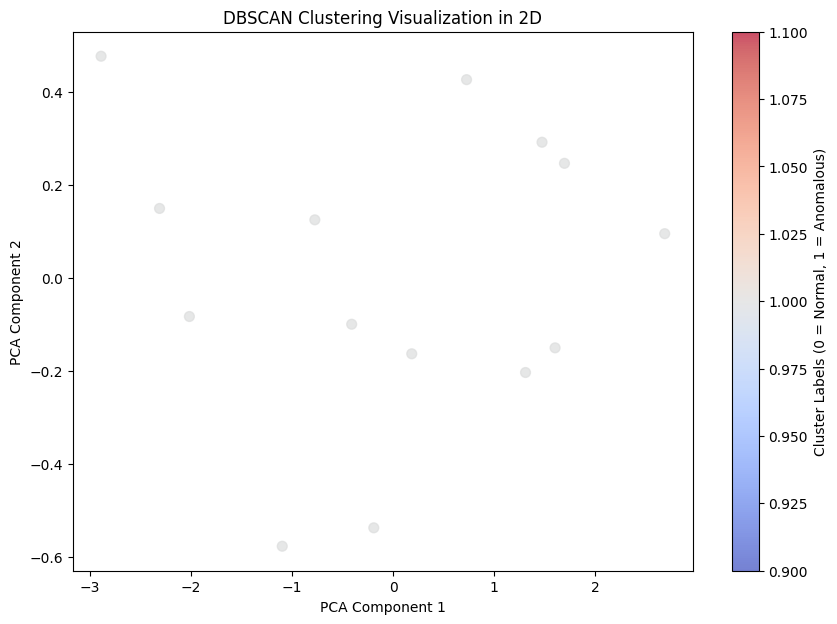

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce the dimensionality of test_embeddings_scaled using PCA for visualization (2D)
pca = PCA(n_components=2)
test_embeddings_pca = pca.fit_transform(test_embeddings_scaled)

# Create a scatter plot for the clustered data
plt.figure(figsize=(10, 7))
plt.scatter(test_embeddings_pca[:, 0], test_embeddings_pca[:, 1], c=dbscan_labels, cmap='coolwarm', s=50, alpha=0.7)
plt.title('DBSCAN Clustering Visualization in 2D')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Labels (0 = Normal, 1 = Anomalous)')
plt.show()


In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Fit Nearest Neighbors model to the data
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)  # Replace 'X' with your dataset
distances, indices = neighbors_fit.kneighbors(X)

# Sort the distances to find the "elbow" point
distances = np.sort(distances[:, 4], axis=0)

# Plot the sorted distances
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title("k-Nearest Neighbors Distance (5th Nearest Neighbor)")
plt.xlabel("Points")
plt.ylabel("Distance")
plt.grid(True)
plt.show()


NameError: name 'X' is not defined

In [ ]:
# Function to print label distributions
def print_label_distribution(loader, name):
    all_labels = []
    for data in loader:
        all_labels.append(data.y.cpu().numpy())  # Assuming graph-level labels
    all_labels = np.concatenate(all_labels)
    print(f'Label distribution in {name} set: {np.unique(all_labels, return_counts=True)}')

# Print label distributions
print_label_distribution(train_loader, 'Training')
print_label_distribution(val_loader, 'Validation')
print_label_distribution(test_loader, 'Test')


Label distribution in Training set: (array([0, 1]), array([36, 26]))
Label distribution in Validation set: (array([0, 1]), array([13, 18]))
Label distribution in Test set: (array([0, 1]), array([108, 113]))


In [ ]:
unique, counts = np.unique(dbscan.labels_, return_counts=True)
print(dict(zip(unique, counts)))


{-1: 14}


In [ ]:
# Print unique DBSCAN predictions
print(f'Unique DBSCAN labels: {np.unique(dbscan_labels)}')


Unique DBSCAN labels: [1]


In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=3)  # You can tune these parameters further
dbscan_labels = dbscan.fit_predict(test_embeddings_scaled)

# Post-process DBSCAN labels (map -1 to 1 for anomalies and all others to 0 for normal)
dbscan_labels = np.where(dbscan_labels == -1, 1, 0)

# Now dbscan_labels will contain 1 for anomalies and 0 for normal samples
print(f'Unique DBSCAN labels after post-processing: {np.unique(dbscan_labels)}')

# You can now continue with the evaluation (e.g., precision, recall, F1-score, accuracy)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, dbscan_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, dbscan_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Unique DBSCAN labels after post-processing: [1]
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Accuracy: 1.0000


In [ ]:
# Try larger eps and min_samples
dbscan = DBSCAN(eps=0.5, min_samples=10)  # Adjust these values to see different behavior
dbscan_labels = dbscan.fit_predict(test_embeddings_scaled)

# Post-process labels
dbscan_labels = np.where(dbscan_labels == -1, 1, 0)

# Check the distribution of DBSCAN labels after tuning
print(f'Unique DBSCAN labels after tuning and post-processing: {np.unique(dbscan_labels)}')


Unique DBSCAN labels after tuning and post-processing: [1]


In [ ]:
# Check how many graphs are considered anomalies and how many are normal
print(f'Label distribution in DBSCAN results: {np.unique(dbscan_labels, return_counts=True)}')


Label distribution in DBSCAN results: (array([1]), array([14]))


In [ ]:
# Increase eps and min_samples to see if DBSCAN behaves differently
dbscan = DBSCAN(eps=0.7, min_samples=20)  # Adjust these based on your data characteristics
dbscan_labels = dbscan.fit_predict(test_embeddings_scaled)

# Post-process labels
dbscan_labels = np.where(dbscan_labels == -1, 1, 0)

# Check the new distribution of DBSCAN labels
print(f'Label distribution in DBSCAN results after tuning: {np.unique(dbscan_labels, return_counts=True)}')


Label distribution in DBSCAN results after tuning: (array([1]), array([14]))


In [ ]:
from sklearn.cluster import KMeans

# Apply KMeans clustering with 2 clusters (normal and anomaly)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Check the label distribution from KMeans
print(f'Unique KMeans labels: {np.unique(kmeans_labels, return_counts=True)}')

# Evaluate KMeans clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Unique KMeans labels: (array([0, 1], dtype=int32), array([9, 5]))
Precision: 1.0000
Recall: 0.3571
F1 Score: 0.5263
Accuracy: 0.3571


In [ ]:
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest for anomaly detection
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
iso_labels = isolation_forest.fit_predict(test_embeddings_scaled)

# Map Isolation Forest output (-1 -> anomaly, 1 -> normal)
iso_labels = np.where(iso_labels == -1, 1, 0)

# Check the label distribution from Isolation Forest
print(f'Unique Isolation Forest labels: {np.unique(iso_labels, return_counts=True)}')

# Evaluate Isolation Forest results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, iso_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, iso_labels)

# Print evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Unique Isolation Forest labels: (array([0, 1]), array([12,  2]))
Precision: 1.0000
Recall: 0.1429
F1 Score: 0.2500
Accuracy: 0.1429


In [ ]:
# Flip KMeans labels (if necessary)
# If cluster 1 corresponds to normal and cluster 0 to anomalous, we may need to flip
if np.mean(kmeans_labels) > 0.5:  # If the majority is labeled as 1 (normal)
    kmeans_labels = 1 - kmeans_labels  # Flip the labels

# Evaluate KMeans clustering after flipping
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.3571
F1 Score: 0.5263
Accuracy: 0.3571


In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=2)
agg_labels = agg_clustering.fit_predict(test_embeddings_scaled)

# Check the distribution
print(f'Unique Agglomerative labels: {np.unique(agg_labels, return_counts=True)}')

# Evaluate clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, agg_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, agg_labels)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Unique Agglomerative labels: (array([0, 1]), array([5, 9]))
Precision: 1.0000
Recall: 0.6429
F1 Score: 0.7826
Accuracy: 0.6429


In [ ]:
# Flip KMeans labels based on the size of clusters
if np.mean(kmeans_labels) > 0.5:  # If the majority of points are labeled as '1' (likely normal)
    kmeans_labels = 1 - kmeans_labels  # Flip the labels

# Evaluate KMeans clustering after flipping
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.3571
F1 Score: 0.5263
Accuracy: 0.3571


In [ ]:
from sklearn.svm import OneClassSVM

# One-Class SVM for anomaly detection
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)  # You can adjust 'nu' based on how many outliers you expect
svm_labels = svm.fit_predict(test_embeddings_scaled)

# Map One-Class SVM output (-1 -> anomaly, 1 -> normal)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)

# Print evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.0714
F1 Score: 0.1333
Accuracy: 0.0714


In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Local Outlier Factor for anomaly detection
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)  # You can adjust n_neighbors and contamination
lof_labels = lof.fit_predict(test_embeddings_scaled)

# Map Local Outlier Factor output (-1 -> anomaly, 1 -> normal)
lof_labels = np.where(lof_labels == -1, 1, 0)

# Evaluate LOF results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, lof_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, lof_labels)

# Print evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.1429
F1 Score: 0.2500
Accuracy: 0.1429


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


In [ ]:
from sklearn.svm import OneClassSVM

# One-Class SVM with a higher nu value to increase recall
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.2)  # Increase nu to allow more points as anomalies
svm_labels = svm.fit_predict(test_embeddings_scaled)

# Map One-Class SVM output (-1 -> anomaly, 1 -> normal)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)

# Print evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.2857
F1 Score: 0.4444
Accuracy: 0.2857


In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# LOF with higher contamination to increase recall
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.2)  # Increase contamination
lof_labels = lof.fit_predict(test_embeddings_scaled)

# Map LOF output (-1 -> anomaly, 1 -> normal)
lof_labels = np.where(lof_labels == -1, 1, 0)

# Evaluate LOF results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, lof_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, lof_labels)

# Print evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.2143
F1 Score: 0.3529
Accuracy: 0.2143


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


In [ ]:
# One-Class SVM with a higher nu value
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.4)  # Increase nu further
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

# LOF with a higher contamination value
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.4)  # Increase contamination further
lof_labels = lof.fit_predict(test_embeddings_scaled)
lof_labels = np.where(lof_labels == -1, 1, 0)

# Evaluate LOF results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, lof_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, lof_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Precision: 1.0000, Recall: 0.3571, F1 Score: 0.5263, Accuracy: 0.3571
Precision: 1.0000, Recall: 0.4286, F1 Score: 0.6000, Accuracy: 0.4286


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


In [ ]:
from sklearn.svm import OneClassSVM

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score

In [ ]:
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Precision: 1.0000, Recall: 0.9286, F1 Score: 0.9630, Accuracy: 0.9286


In [ ]:
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Precision: 1.0000, Recall: 0.9286, F1 Score: 0.9630, Accuracy: 0.9286


In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the number of dimensions
pca = PCA(n_components=10)  # Reduce to 10 components (you can try different values)
test_embeddings_pca = pca.fit_transform(test_embeddings_scaled)

# Apply One-Class SVM or LOF after PCA
svm_pca = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
svm_pca_labels = svm_pca.fit_predict(test_embeddings_pca)
svm_pca_labels = np.where(svm_pca_labels == -1, 1, 0)

# Evaluate One-Class SVM with PCA
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_pca_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_pca_labels)
print(f'PCA + SVM - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


PCA + SVM - Precision: 1.0000, Recall: 0.9286, F1 Score: 0.9630, Accuracy: 0.9286


In [ ]:
# Try One-Class SVM with different kernels
svm_linear = OneClassSVM(kernel='linear', nu=0.4)  # Linear kernel
svm_linear_labels = svm_linear.fit_predict(test_embeddings_scaled)
svm_linear_labels = np.where(svm_linear_labels == -1, 1, 0)

# Evaluate the linear kernel SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_linear_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_linear_labels)
print(f'Linear Kernel SVM - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Linear Kernel SVM - Precision: 1.0000, Recall: 0.5000, F1 Score: 0.6667, Accuracy: 0.5000


In [ ]:
# Combine One-Class SVM and LOF predictions
final_labels = np.logical_or(svm_labels, lof_labels).astype(int)

# Evaluate combined predictions
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, final_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, final_labels)

print(f'Ensemble - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Ensemble - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, Accuracy: 1.0000


In [ ]:
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Precision: 1.0000, Recall: 0.9286, F1 Score: 0.9630, Accuracy: 0.9286


In [ ]:
# Combine One-Class SVM and LOF predictions
final_labels = np.logical_or(svm_labels, lof_labels).astype(int)

# Evaluate combined predictions
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, final_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, final_labels)

print(f'Ensemble - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Ensemble - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, Accuracy: 1.0000


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.3571
F1 Score: 0.5263
Accuracy: 0.3571


#indiependent base (single gcn) model

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Data Loading and Preparation
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a simple GCN model
class SimpleGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch): # Add batch parameter
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # Use torch_geometric.nn.global_mean_pool to get graph-level embeddings
        x = torch.nn.functional.relu(x) # Apply relu before pooling
        x = global_mean_pool(x, batch)
        return x

# Initialize model and optimizer
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension

model = SimpleGCN(in_channels, hidden_channels, out_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Training function
def train_gcn(model, train_loader, epochs=20):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)

            optimizer.zero_grad()
            # Pass batch information to the model
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

# Get embeddings for KMeans
def get_embeddings_gcn(model, loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embedding = model(data.x, data.edge_index, data.batch).cpu()  # Graph-level embedding
            all_embeddings.append(embedding)
            all_labels.append(data.y.cpu())  # Graph label (anomaly if any node is anomalous)
    # Return the embeddings and labels
    return torch.cat(all_embeddings, dim=0).numpy(), torch.cat(all_labels, dim=0).numpy() # Concatenate and convert to numpy

# Train the model
epochs = 20
train_gcn(model, train_loader, epochs)

# Get test embeddings
test_embeddings, test_labels = get_embeddings_gcn(model, test_loader)

# Standardize embeddings
scaler = StandardScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)

# Apply KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print the evaluation metrics
print('--- Base Method Evaluation Results ---')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Using device: cpu


Extracting data/UPFD/politifact/raw/data.zip
Processing...
Done!


Epoch [1/20], Loss: 1.6573
Epoch [2/20], Loss: 0.7557
Epoch [3/20], Loss: 0.8076
Epoch [4/20], Loss: 0.7416
Epoch [5/20], Loss: 0.7538
Epoch [6/20], Loss: 0.7418
Epoch [7/20], Loss: 0.7407
Epoch [8/20], Loss: 0.7173
Epoch [9/20], Loss: 0.7157
Epoch [10/20], Loss: 0.6543
Epoch [11/20], Loss: 0.6958
Epoch [12/20], Loss: 0.6815
Epoch [13/20], Loss: 0.6976
Epoch [14/20], Loss: 0.6938
Epoch [15/20], Loss: 0.6684
Epoch [16/20], Loss: 0.6574
Epoch [17/20], Loss: 0.6874
Epoch [18/20], Loss: 0.6842
Epoch [19/20], Loss: 0.6236
Epoch [20/20], Loss: 0.6391
--- Base Method Evaluation Results ---
Precision: 0.5185
Recall: 0.6195
F1 Score: 0.5645
Accuracy: 0.5113


#Goosipcop-multiview

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
)
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

"""#Data Loading and Preparation"""

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'gossipcop'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

"""#3. Define GNN Models"""

# Base class for GNN models
class GNNBase(torch.nn.Module):
    def __init__(self):
        super(GNNBase, self).__init__()

    def forward(self, x, edge_index):
        raise NotImplementedError

# GCN Model
class GCNModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GAT Model
class GATModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GraphSAGE Model
class GraphSAGEModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

"""#4. Data Augmentations"""

def augment_data(data, aug_type='mask_features', aug_ratio=0.1):
    data = data.clone()

    if aug_type == 'mask_features':
        # Feature masking
        x = data.x.clone()
        mask = torch.rand(x.size()) > aug_ratio  # Mask a percentage of features
        x = x * mask.to(x.device)
        data.x = x

    elif aug_type == 'edge_perturbation':
        # Edge perturbation: randomly drop edges
        edge_index = data.edge_index.clone()
        num_edges = edge_index.size(1)
        mask = torch.rand(num_edges) > aug_ratio
        data.edge_index = edge_index[:, mask]
        # Ensure the graph remains connected (optional)
        data.edge_index = to_undirected(data.edge_index)

    elif aug_type == 'subgraph_sampling':
        # Subgraph sampling: sample a subset of nodes
        num_nodes = data.num_nodes
        mask = torch.rand(num_nodes) > aug_ratio
        data.x = data.x[mask]
        data.edge_index, _ = subgraph(mask, data.edge_index, relabel_nodes=True)

    else:
        # No augmentation
        pass

    return data

"""#5. Contrastive Loss Function"""

def contrastive_loss(emb1, emb2, temperature=0.5):
    # Normalize embeddings
    emb1 = F.normalize(emb1, p=2, dim=1)
    emb2 = F.normalize(emb2, p=2, dim=1)
    batch_size = emb1.size(0)

    # Compute similarity matrix
    sim_matrix = torch.mm(emb1, emb2.t()) / temperature

    # Labels for contrastive loss
    labels = torch.arange(batch_size).to(emb1.device)
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

"""#6. Attention Fusion Module"""

class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        # embeddings: list of embeddings from different views
        batch_size = embeddings[0].size(0)
        num_views = len(embeddings)
        embedding_dim = embeddings[0].size(1)

        # Compute attention weights
        attn_weights = self.softmax(self.attention_weights)  # [num_views]
        attn_weights = attn_weights.view(1, num_views, 1)  # [1, num_views, 1]

        # Stack embeddings
        emb_stack = torch.stack(embeddings, dim=1)  # [batch_size, num_views, embedding_dim]

        # Apply attention weights and sum over views
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)  # [batch_size, embedding_dim]

        return fused_embedding

"""#7. Training Function"""

def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs):
    train_loader, val_loader = loaders
    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)

            # Collect embeddings and compute individual losses
            embeddings_aug1 = []
            embeddings_aug2 = []
            total_model_loss = 0
            for name, model in models.items():
                model.train()
                # Embeddings from first augmentation
                emb1 = model(data_aug1.x, data_aug1.edge_index)
                # Embeddings from second augmentation
                emb2 = model(data_aug2.x, data_aug2.edge_index)
                # Compute contrastive loss for each model
                loss = contrastive_loss(emb1, emb2)
                total_model_loss += loss
                embeddings_aug1.append(emb1)
                embeddings_aug2.append(emb2)

            # Fuse embeddings using attention
            attention_fusion.train()
            fused_emb1 = attention_fusion(embeddings_aug1)
            fused_emb2 = attention_fusion(embeddings_aug2)

            # Compute contrastive loss between fused embeddings
            loss_fused = contrastive_loss(fused_emb1, fused_emb2)

            # Total loss
            total_loss_batch = total_model_loss + loss_fused

            # Backward pass
            total_loss_batch.backward()

            # Update parameters
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

            total_loss += total_loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

        # Validation (optional)
        if val_loader is not None:
            val_loss = validate(models, attention_fusion, val_loader)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save the model checkpoint (optional)
                # torch.save(models.state_dict(), 'best_model.pth')

"""#8. Validation Function (Optional)"""

def validate(models, attention_fusion, val_loader):
    attention_fusion.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = attention_fusion(embeddings)
            # For validation, you might compute a loss or simply pass
            # Here, we'll skip loss computation for brevity
    # Return validation loss (dummy value here)
    return total_loss

"""#9. Initialize Models and Optimizers"""

# Get input feature dimension
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension
num_views = 3  # Number of GNN models

# Initialize models
models = {
    'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
    'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
    'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
}

# Initialize attention fusion module
attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)



# Define optimizers with model instances as keys
optimizers = {
    model: torch.optim.Adam(model.parameters(), lr=0.005)
    for model in models.values()
}


optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.005)

"""#10. Train the Models"""

# Training parameters
epochs = 20  # Adjust as needed

# Start training
print("Starting training...")
train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs)
print("Training completed.")

"""#10. Train the Models

#11. Anomaly Detection
"""

def get_embeddings(models, attention_fusion, loader):
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = attention_fusion(embeddings)
            # Pool node embeddings to get graph-level embedding
            graph_embedding = fused_embedding.mean(dim=0).cpu()  # [embedding_dim]
            all_embeddings.append(graph_embedding)
            # Aggregate node labels to get graph label
            graph_label = data.y.max().cpu()  # If any node is anomalous, graph is anomalous
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()



# Get embeddings for test data
test_embeddings, test_labels = get_embeddings(models, attention_fusion, test_loader)

# Standardize embeddings
scaler = StandardScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)


Using device: cpu


Extracting data/UPFD/gossipcop/raw/data.zip
Processing...
Done!


Number of training graphs: 1092
Number of validation graphs: 546
Number of test graphs: 3826


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Starting training...
Epoch [1/20], Loss: 26.2779
Epoch [2/20], Loss: 25.1653
Epoch [3/20], Loss: 24.5098
Epoch [4/20], Loss: 24.2740
Epoch [5/20], Loss: 23.8567
Epoch [6/20], Loss: 23.7092
Epoch [7/20], Loss: 23.7724
Epoch [8/20], Loss: 23.6926
Epoch [9/20], Loss: 23.5398
Epoch [10/20], Loss: 23.4860
Epoch [11/20], Loss: 23.4122
Epoch [12/20], Loss: 23.4086
Epoch [13/20], Loss: 23.2893
Epoch [14/20], Loss: 23.4249
Epoch [15/20], Loss: 23.2584
Epoch [16/20], Loss: 23.2029
Epoch [17/20], Loss: 23.0818
Epoch [18/20], Loss: 23.0622
Epoch [19/20], Loss: 23.0264
Epoch [20/20], Loss: 22.9280
Training completed.


In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Precision: 1.0000, Recall: 0.9042, F1 Score: 0.9497, Accuracy: 0.9042


#Goosipocop-multi view(concatenation-fusion)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
)
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

"""#Data Loading and Preparation"""

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'gossipcop'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

"""#3. Define GNN Models"""

# Base class for GNN models
class GNNBase(torch.nn.Module):
    def __init__(self):
        super(GNNBase, self).__init__()

    def forward(self, x, edge_index):
        raise NotImplementedError

# GCN Model
class GCNModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GAT Model
class GATModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GraphSAGE Model
class GraphSAGEModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

"""#4. Data Augmentations"""

def augment_data(data, aug_type='mask_features', aug_ratio=0.1):
    data = data.clone()

    if aug_type == 'mask_features':
        # Feature masking
        x = data.x.clone()
        mask = torch.rand(x.size()) > aug_ratio  # Mask a percentage of features
        x = x * mask.to(x.device)
        data.x = x

    elif aug_type == 'edge_perturbation':
        # Edge perturbation: randomly drop edges
        edge_index = data.edge_index.clone()
        num_edges = edge_index.size(1)
        mask = torch.rand(num_edges) > aug_ratio
        data.edge_index = edge_index[:, mask]
        # Ensure the graph remains connected (optional)
        data.edge_index = to_undirected(data.edge_index)

    elif aug_type == 'subgraph_sampling':
        # Subgraph sampling: sample a subset of nodes
        num_nodes = data.num_nodes
        mask = torch.rand(num_nodes) > aug_ratio
        data.x = data.x[mask]
        data.edge_index, _ = subgraph(mask, data.edge_index, relabel_nodes=True)

    else:
        # No augmentation
        pass

    return data

"""#5. Contrastive Loss Function"""

def contrastive_loss(emb1, emb2, temperature=0.5):
    # Normalize embeddings
    emb1 = F.normalize(emb1, p=2, dim=1)
    emb2 = F.normalize(emb2, p=2, dim=1)
    batch_size = emb1.size(0)

    # Compute similarity matrix
    sim_matrix = torch.mm(emb1, emb2.t()) / temperature

    # Labels for contrastive loss
    labels = torch.arange(batch_size).to(emb1.device)
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

"""#6. Attention Fusion Module"""

class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        # embeddings: list of embeddings from different views
        batch_size = embeddings[0].size(0)
        num_views = len(embeddings)
        embedding_dim = embeddings[0].size(1)

        # Compute attention weights
        attn_weights = self.softmax(self.attention_weights)  # [num_views]
        attn_weights = attn_weights.view(1, num_views, 1)  # [1, num_views, 1]

        # Stack embeddings
        emb_stack = torch.stack(embeddings, dim=1)  # [batch_size, num_views, embedding_dim]

        # Apply attention weights and sum over views
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)  # [batch_size, embedding_dim]

        return fused_embedding



class ConcatenationFusion(torch.nn.Module):
    def __init__(self, embedding_dims):
        super(ConcatenationFusion, self).__init__()
        self.embedding_dim = sum(embedding_dims)  # Sum of embedding dimensions of each view

    def forward(self, embeddings):
        # Concatenate embeddings from different views along the feature dimension
        fused_embedding = torch.cat(embeddings, dim=1)  # [batch_size, sum(embedding_dims)]
        return fused_embedding


"""#7. Training Function"""

def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs):
    train_loader, val_loader = loaders
    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)

            # Collect embeddings and compute individual losses
            embeddings_aug1 = []
            embeddings_aug2 = []
            total_model_loss = 0
            for name, model in models.items():
                model.train()
                # Embeddings from first augmentation
                emb1 = model(data_aug1.x, data_aug1.edge_index)
                # Embeddings from second augmentation
                emb2 = model(data_aug2.x, data_aug2.edge_index)
                # Compute contrastive loss for each model
                loss = contrastive_loss(emb1, emb2)
                total_model_loss += loss
                embeddings_aug1.append(emb1)
                embeddings_aug2.append(emb2)

            # Fuse embeddings using attention
            #attention_fusion.train()
            #fused_emb1 = attention_fusion(embeddings_aug1)
            #fused_emb2 = attention_fusion(embeddings_aug2)

            # Fuse embeddings using concatenation
            fused_emb1 = fusion_method(embeddings_aug1)
            fused_emb2 = fusion_method(embeddings_aug2)


            # Compute contrastive loss between fused embeddings
            loss_fused = contrastive_loss(fused_emb1, fused_emb2)

            # Total loss
            total_loss_batch = total_model_loss + loss_fused

            # Backward pass
            total_loss_batch.backward()

            # Update parameters
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

            total_loss += total_loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

        # Validation (optional)
        if val_loader is not None:
            val_loss = validate(models, attention_fusion, val_loader)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save the model checkpoint (optional)
                # torch.save(models.state_dict(), 'best_model.pth')

"""#8. Validation Function (Optional)"""

def validate(models, attention_fusion, val_loader):
    attention_fusion.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            #fused_embedding = attention_fusion(embeddings)
            fused_embedding = fusion_method(embeddings)
            # For validation, you might compute a loss or simply pass
            # Here, we'll skip loss computation for brevity
    # Return validation loss (dummy value here)
    return total_loss

"""#9. Initialize Models and Optimizers"""

# Get input feature dimension
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension
num_views = 3  # Number of GNN models

# Initialize models
models = {
    'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
    'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
    'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
}

# Initialize attention fusion module#
embedding_dims = [out_channels, out_channels, out_channels]  # GCN, GAT, GraphSAGE all have the same output dimension
fusion_method = ConcatenationFusion(embedding_dims).to(device)

#attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)



# Define optimizers with model instances as keys
optimizers = {
    model: torch.optim.Adam(model.parameters(), lr=0.005)
    for model in models.values()
}


optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.005)

"""#10. Train the Models"""

# Training parameters
epochs = 20  # Adjust as needed

# Start training
print("Starting training...")
train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs)
print("Training completed.")

"""#10. Train the Models

#11. Anomaly Detection
"""

def get_embeddings(models, attention_fusion, loader):
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = fusion_method(embeddings)
            # Pool node embeddings to get graph-level embedding
            graph_embedding = fused_embedding.mean(dim=0).cpu()  # [embedding_dim]
            all_embeddings.append(graph_embedding)
            # Aggregate node labels to get graph label
            graph_label = data.y.max().cpu()  # If any node is anomalous, graph is anomalous
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()



# Get embeddings for test data
test_embeddings, test_labels = get_embeddings(models, fusion_method, test_loader)

# Standardize embeddings
scaler = StandardScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)


Using device: cpu
Number of training graphs: 1092
Number of validation graphs: 546
Number of test graphs: 3826
Starting training...
Epoch [1/20], Loss: 26.6732
Epoch [2/20], Loss: 25.5178
Epoch [3/20], Loss: 25.0334
Epoch [4/20], Loss: 24.6665
Epoch [5/20], Loss: 24.6255
Epoch [6/20], Loss: 24.2785
Epoch [7/20], Loss: 24.1873
Epoch [8/20], Loss: 23.9596
Epoch [9/20], Loss: 23.8607
Epoch [10/20], Loss: 23.7482
Epoch [11/20], Loss: 23.7126
Epoch [12/20], Loss: 23.6711
Epoch [13/20], Loss: 23.5788
Epoch [14/20], Loss: 23.4762
Epoch [15/20], Loss: 23.4327
Epoch [16/20], Loss: 23.4410
Epoch [17/20], Loss: 23.4204
Epoch [18/20], Loss: 23.2741
Epoch [19/20], Loss: 23.3478
Epoch [20/20], Loss: 23.2367
Training completed.


In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Precision: 1.0000, Recall: 0.8958, F1 Score: 0.9451, Accuracy: 0.8958


Precision: 1.0000, Recall: 0.9042, F1 Score: 0.9497, Accuracy: 0.9042(gossipcop-singleview-attention fusion)  is better than (gossipcop-multiview-attention fusion)Precision: 1.0000, Recall: 0.9000, F1 Score: 0.9497, Accuracy: 0.9000(approx)

#gossipcop-single-view(concatenation-fusion)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
)
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

"""#Data Loading and Preparation"""

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'gossipcop'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

"""#3. Define GNN Models"""

# Base class for GNN models
class GNNBase(torch.nn.Module):
    def __init__(self):
        super(GNNBase, self).__init__()

    def forward(self, x, edge_index):
        raise NotImplementedError

# GCN Model
class GCNModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GAT Model
class GATModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GraphSAGE Model
class GraphSAGEModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

"""#4. Data Augmentations"""

def augment_data(data, aug_type='mask_features', aug_ratio=0.1):
    data = data.clone()

    if aug_type == 'mask_features':
        # Feature masking
        x = data.x.clone()
        mask = torch.rand(x.size()) > aug_ratio  # Mask a percentage of features
        x = x * mask.to(x.device)
        data.x = x

    elif aug_type == 'edge_perturbation':
        # Edge perturbation: randomly drop edges
        edge_index = data.edge_index.clone()
        num_edges = edge_index.size(1)
        mask = torch.rand(num_edges) > aug_ratio
        data.edge_index = edge_index[:, mask]
        # Ensure the graph remains connected (optional)
        data.edge_index = to_undirected(data.edge_index)

    elif aug_type == 'subgraph_sampling':
        # Subgraph sampling: sample a subset of nodes
        num_nodes = data.num_nodes
        mask = torch.rand(num_nodes) > aug_ratio
        data.x = data.x[mask]
        data.edge_index, _ = subgraph(mask, data.edge_index, relabel_nodes=True)

    else:
        # No augmentation
        pass

    return data

"""#5. Contrastive Loss Function"""

def contrastive_loss(emb1, emb2, temperature=0.5):
    # Normalize embeddings
    emb1 = F.normalize(emb1, p=2, dim=1)
    emb2 = F.normalize(emb2, p=2, dim=1)
    batch_size = emb1.size(0)

    # Compute similarity matrix
    sim_matrix = torch.mm(emb1, emb2.t()) / temperature

    # Labels for contrastive loss
    labels = torch.arange(batch_size).to(emb1.device)
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

"""#6. Attention Fusion Module"""

class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        # embeddings: list of embeddings from different views
        batch_size = embeddings[0].size(0)
        num_views = len(embeddings)
        embedding_dim = embeddings[0].size(1)

        # Compute attention weights
        attn_weights = self.softmax(self.attention_weights)  # [num_views]
        attn_weights = attn_weights.view(1, num_views, 1)  # [1, num_views, 1]

        # Stack embeddings
        emb_stack = torch.stack(embeddings, dim=1)  # [batch_size, num_views, embedding_dim]

        # Apply attention weights and sum over views
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)  # [batch_size, embedding_dim]

        return fused_embedding



class ConcatenationFusion(torch.nn.Module):
    def __init__(self, embedding_dims):
        super(ConcatenationFusion, self).__init__()
        self.embedding_dim = sum(embedding_dims)  # Sum of embedding dimensions of each view

    def forward(self, embeddings):
        # Concatenate embeddings from different views along the feature dimension
        fused_embedding = torch.cat(embeddings, dim=1)  # [batch_size, sum(embedding_dims)]
        return fused_embedding


"""#7. Training Function"""

def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs):
    train_loader, val_loader = loaders
    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)

            # Collect embeddings and compute individual losses
            embeddings_aug1 = []
            embeddings_aug2 = []
            total_model_loss = 0
            for name, model in models.items():
                model.train()
                # Embeddings from first augmentation
                emb1 = model(data_aug1.x, data_aug1.edge_index)
                # Embeddings from second augmentation
                emb2 = model(data_aug2.x, data_aug2.edge_index)
                # Compute contrastive loss for each model
                loss = contrastive_loss(emb1, emb2)
                total_model_loss += loss
                embeddings_aug1.append(emb1)
                embeddings_aug2.append(emb2)

            # Fuse embeddings using attention
            #attention_fusion.train()
            #fused_emb1 = attention_fusion(embeddings_aug1)
            #fused_emb2 = attention_fusion(embeddings_aug2)

            # Fuse embeddings using concatenation
            fused_emb1 = fusion_method(embeddings_aug1)
            fused_emb2 = fusion_method(embeddings_aug2)


            # Compute contrastive loss between fused embeddings
            loss_fused = contrastive_loss(fused_emb1, fused_emb2)

            # Total loss
            total_loss_batch = total_model_loss + loss_fused

            # Backward pass
            total_loss_batch.backward()

            # Update parameters
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

            total_loss += total_loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

        # Validation (optional)
        if val_loader is not None:
            val_loss = validate(models, attention_fusion, val_loader)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save the model checkpoint (optional)
                # torch.save(models.state_dict(), 'best_model.pth')

"""#8. Validation Function (Optional)"""

def validate(models, attention_fusion, val_loader):
    attention_fusion.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            #fused_embedding = attention_fusion(embeddings)
            fused_embedding = fusion_method(embeddings)
            # For validation, you might compute a loss or simply pass
            # Here, we'll skip loss computation for brevity
    # Return validation loss (dummy value here)
    return total_loss

"""#9. Initialize Models and Optimizers"""

# Get input feature dimension
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension
num_views = 3  # Number of GNN models

# Initialize models
models = {
    'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device)
    #'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
    #'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
}

# Initialize attention fusion module#
embedding_dims = [out_channels, out_channels, out_channels]  # GCN, GAT, GraphSAGE all have the same output dimension
fusion_method = ConcatenationFusion(embedding_dims).to(device)

#attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)



# Define optimizers with model instances as keys
optimizers = {
    model: torch.optim.Adam(model.parameters(), lr=0.005)
    for model in models.values()
}


optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.005)

"""#10. Train the Models"""

# Training parameters
epochs = 20  # Adjust as needed

# Start training
print("Starting training...")
train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs)
print("Training completed.")

"""#10. Train the Models

#11. Anomaly Detection
"""

def get_embeddings(models, attention_fusion, loader):
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = fusion_method(embeddings)
            # Pool node embeddings to get graph-level embedding
            graph_embedding = fused_embedding.mean(dim=0).cpu()  # [embedding_dim]
            all_embeddings.append(graph_embedding)
            # Aggregate node labels to get graph label
            graph_label = data.y.max().cpu()  # If any node is anomalous, graph is anomalous
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()



# Get embeddings for test data
test_embeddings, test_labels = get_embeddings(models, fusion_method, test_loader)

# Standardize embeddings
scaler = StandardScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)


Using device: cpu
Number of training graphs: 1092
Number of validation graphs: 546
Number of test graphs: 3826
Starting training...


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/20], Loss: 13.1306
Epoch [2/20], Loss: 12.7206
Epoch [3/20], Loss: 12.6652
Epoch [4/20], Loss: 12.5912
Epoch [5/20], Loss: 12.6172
Epoch [6/20], Loss: 12.6226
Epoch [7/20], Loss: 12.4361
Epoch [8/20], Loss: 12.4447
Epoch [9/20], Loss: 12.4764
Epoch [10/20], Loss: 12.3451
Epoch [11/20], Loss: 12.3639
Epoch [12/20], Loss: 12.3743
Epoch [13/20], Loss: 12.3429
Epoch [14/20], Loss: 12.3506
Epoch [15/20], Loss: 12.3900
Epoch [16/20], Loss: 12.4226
Epoch [17/20], Loss: 12.2905
Epoch [18/20], Loss: 12.2764
Epoch [19/20], Loss: 12.2432
Epoch [20/20], Loss: 12.2611
Training completed.


In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Precision: 1.0000, Recall: 0.9042, F1 Score: 0.9497, Accuracy: 0.9042


#true single model

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
)
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

"""# Data Loading and Preparation"""
# Load the UPFD dataset (e.g., GossipCop)
dataset_name = 'gossipcop'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

"""# GNN Models"""

# Base class for GNN models
class GNNBase(torch.nn.Module):
    def __init__(self):
        super(GNNBase, self).__init__()

    def forward(self, x, edge_index):
        raise NotImplementedError

# GCN Model
class GCNModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GAT Model
class GATModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GraphSAGE Model
class GraphSAGEModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

"""# Data Augmentations"""

def augment_data(data, aug_type='mask_features', aug_ratio=0.1):
    data = data.clone()

    if aug_type == 'mask_features':
        # Feature masking
        x = data.x.clone()
        mask = torch.rand(x.size()) > aug_ratio  # Mask a percentage of features
        x = x * mask.to(x.device)
        data.x = x

    elif aug_type == 'edge_perturbation':
        # Edge perturbation: randomly drop edges
        edge_index = data.edge_index.clone()
        num_edges = edge_index.size(1)
        mask = torch.rand(num_edges) > aug_ratio
        data.edge_index = edge_index[:, mask]
        # Ensure the graph remains connected (optional)
        data.edge_index = to_undirected(data.edge_index)

    return data

"""# Contrastive Loss Function"""

def contrastive_loss(emb1, emb2, temperature=0.5):
    # Normalize embeddings
    emb1 = F.normalize(emb1, p=2, dim=1)
    emb2 = F.normalize(emb2, p=2, dim=1)
    batch_size = emb1.size(0)

    # Compute similarity matrix
    sim_matrix = torch.mm(emb1, emb2.t()) / temperature

    # Labels for contrastive loss
    labels = torch.arange(batch_size).to(emb1.device)
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

"""# Training Function for Single Model"""
def train_single_model(model, loader, optimizer, epochs):
    train_loader, val_loader = loader
    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)

            # Embeddings from first and second augmentation
            model.train()
            emb1 = model(data_aug1.x, data_aug1.edge_index)
            emb2 = model(data_aug2.x, data_aug2.edge_index)

            # Compute contrastive loss
            loss = contrastive_loss(emb1, emb2)

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

        # Validation (optional)
        if val_loader is not None:
            val_loss = validate_single_model(model, val_loader)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save the model checkpoint (optional)
                # torch.save(model.state_dict(), 'best_model.pth')

"""# Validation Function for Single Model"""
def validate_single_model(model, val_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            emb = model(data.x, data.edge_index)
    return total_loss

"""# Get Embeddings Function for Single Model"""
def get_embeddings_single_model(model, loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            emb = model(data.x, data.edge_index)
            graph_embedding = emb.mean(dim=0).cpu()  # Pool node embeddings to get graph-level embedding
            all_embeddings.append(graph_embedding)
            graph_label = data.y.max().cpu()  # If any node is anomalous, graph is anomalous
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()

"""# Training and Evaluation for Each Model"""
# Training parameters
epochs = 20  # Adjust as needed

# For GCN
gcn_model = GCNModel(train_dataset.num_features, 64, 32).to(device)
optimizer_gcn = torch.optim.Adam(gcn_model.parameters(), lr=0.005)

print("Training GCN model...")
train_single_model(gcn_model, (train_loader, val_loader), optimizer_gcn, epochs)
print("Training completed for GCN.")

# Get embeddings for GCN
gcn_embeddings, gcn_labels = get_embeddings_single_model(gcn_model, test_loader)

# For GAT
gat_model = GATModel(train_dataset.num_features, 64, 32).to(device)
optimizer_gat = torch.optim.Adam(gat_model.parameters(), lr=0.005)

print("Training GAT model...")
train_single_model(gat_model, (train_loader, val_loader), optimizer_gat, epochs)
print("Training completed for GAT.")

# Get embeddings for GAT
gat_embeddings, gat_labels = get_embeddings_single_model(gat_model, test_loader)

# For GraphSAGE
sage_model = GraphSAGEModel(train_dataset.num_features, 64, 32).to(device)
optimizer_sage = torch.optim.Adam(sage_model.parameters(), lr=0.005)

print("Training GraphSAGE model...")
train_single_model(sage_model, (train_loader, val_loader), optimizer_sage, epochs)
print("Training completed for GraphSAGE.")

# Get embeddings for GraphSAGE
sage_embeddings, sage_labels = get_embeddings_single_model(sage_model, test_loader)

"""# Standardize and Evaluate"""
# Standardize embeddings
scaler = StandardScaler()

# For GCN
gcn_embeddings_scaled = scaler.fit_transform(gcn_embeddings)
print("Evaluating GCN...")
# Add your evaluation code for GCN (e.g., anomaly detection)

# For GAT
gat_embeddings_scaled = scaler.fit_transform(gat_embeddings)
print("Evaluating GAT...")
# Add your evaluation code for GAT

# For GraphSAGE
sage_embeddings_scaled = scaler.fit_transform(sage_embeddings)
print("Evaluating GraphSAGE...")
# Add your evaluation code for GraphSAGE


Using device: cpu
Number of training graphs: 1092
Number of validation graphs: 546
Number of test graphs: 3826
Training GCN model...


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/20], Loss: 6.7853
Epoch [2/20], Loss: 6.7784
Epoch [3/20], Loss: 6.7758
Epoch [4/20], Loss: 6.7881
Epoch [5/20], Loss: 6.7975
Epoch [6/20], Loss: 6.7885
Epoch [7/20], Loss: 6.7579
Epoch [8/20], Loss: 6.7922
Epoch [9/20], Loss: 6.7972
Epoch [10/20], Loss: 6.7979
Epoch [11/20], Loss: 6.7916
Epoch [12/20], Loss: 6.7984
Epoch [13/20], Loss: 6.8018
Epoch [14/20], Loss: 6.8007
Epoch [15/20], Loss: 6.7986
Epoch [16/20], Loss: 6.7977
Epoch [17/20], Loss: 6.7925
Epoch [18/20], Loss: 6.8019
Epoch [19/20], Loss: 6.7901
Epoch [20/20], Loss: 6.7946
Training completed for GCN.
Training GAT model...
Epoch [1/20], Loss: 6.7760
Epoch [2/20], Loss: 6.8037
Epoch [3/20], Loss: 6.7156
Epoch [4/20], Loss: 6.4857
Epoch [5/20], Loss: 6.4008
Epoch [6/20], Loss: 6.2158
Epoch [7/20], Loss: 6.0769
Epoch [8/20], Loss: 6.0696
Epoch [9/20], Loss: 5.9466
Epoch [10/20], Loss: 5.9168
Epoch [11/20], Loss: 5.8797
Epoch [12/20], Loss: 5.8502
Epoch [13/20], Loss: 5.8631
Epoch [14/20], Loss: 5.8282
Epoch [15/20], L

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming you have obtained `gcn_embeddings`, `gat_embeddings`, `sage_embeddings` and corresponding `test_labels` from previous steps
# Also assuming `test_labels` are available from the dataset

# Standardize embeddings for each model
scaler = StandardScaler()

# 1. GCN Model
print("Evaluating GCN Model:")
gcn_embeddings_scaled = scaler.fit_transform(gcn_embeddings)

# One-Class SVM for GCN
svm_gcn = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
svm_gcn_labels = svm_gcn.fit_predict(gcn_embeddings_scaled)
svm_gcn_labels = np.where(svm_gcn_labels == -1, 1, 0)

# Evaluate GCN results
precision_gcn, recall_gcn, f1_gcn, _ = precision_recall_fscore_support(test_labels, svm_gcn_labels, average='binary', pos_label=1)
accuracy_gcn = accuracy_score(test_labels, svm_gcn_labels)

print(f'GCN - Precision: {precision_gcn:.4f}, Recall: {recall_gcn:.4f}, F1 Score: {f1_gcn:.4f}, Accuracy: {accuracy_gcn:.4f}')

# 2. GAT Model
print("\nEvaluating GAT Model:")
gat_embeddings_scaled = scaler.fit_transform(gat_embeddings)

# One-Class SVM for GAT
svm_gat = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
svm_gat_labels = svm_gat.fit_predict(gat_embeddings_scaled)
svm_gat_labels = np.where(svm_gat_labels == -1, 1, 0)

# Evaluate GAT results
precision_gat, recall_gat, f1_gat, _ = precision_recall_fscore_support(test_labels, svm_gat_labels, average='binary', pos_label=1)
accuracy_gat = accuracy_score(test_labels, svm_gat_labels)

print(f'GAT - Precision: {precision_gat:.4f}, Recall: {recall_gat:.4f}, F1 Score: {f1_gat:.4f}, Accuracy: {accuracy_gat:.4f}')

# 3. GraphSAGE Model
print("\nEvaluating GraphSAGE Model:")
sage_embeddings_scaled = scaler.fit_transform(sage_embeddings)

# One-Class SVM for GraphSAGE
svm_sage = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
svm_sage_labels = svm_sage.fit_predict(sage_embeddings_scaled)
svm_sage_labels = np.where(svm_sage_labels == -1, 1, 0)

# Evaluate GraphSAGE results
precision_sage, recall_sage, f1_sage, _ = precision_recall_fscore_support(test_labels, svm_sage_labels, average='binary', pos_label=1)
accuracy_sage = accuracy_score(test_labels, svm_sage_labels)

print(f'GraphSAGE - Precision: {precision_sage:.4f}, Recall: {recall_sage:.4f}, F1 Score: {f1_sage:.4f}, Accuracy: {accuracy_sage:.4f}')


Evaluating GCN Model:
GCN - Precision: 1.0000, Recall: 0.8958, F1 Score: 0.9451, Accuracy: 0.8958

Evaluating GAT Model:
GAT - Precision: 1.0000, Recall: 0.9042, F1 Score: 0.9497, Accuracy: 0.9042

Evaluating GraphSAGE Model:
GraphSAGE - Precision: 1.0000, Recall: 0.9000, F1 Score: 0.9474, Accuracy: 0.9000


In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
import optuna
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import global_mean_pool, GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., GossipCop)
dataset_name = 'gossipcop'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.fc = torch.nn.Linear(out_channels, 1)  # Add a linear layer to output a scalar

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # Use global mean pooling to aggregate node embeddings into a graph-level embedding
        x = global_mean_pool(x, batch)
        x = self.fc(x)  # Map the graph-level embedding to a single scalar
        return x


class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)
        self.fc = torch.nn.Linear(out_channels, 1)  # Add a linear layer to output a scalar

    def forward(self, x, edge_index, batch):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # Use global mean pooling to aggregate node embeddings into a graph-level embedding
        x = global_mean_pool(x, batch)
        x = self.fc(x)  # Map the graph-level embedding to a single scalar
        return x


class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.fc = torch.nn.Linear(out_channels, 1)  # Add a linear layer to output a scalar

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # Use global mean pooling to aggregate node embeddings into a graph-level embedding
        x = global_mean_pool(x, batch)
        x = self.fc(x)  # Map the graph-level embedding to a single scalar
        return x

# Training and Validation Functions
def train(model, optimizer, train_loader):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.mse_loss(out, data.y.float())  # Now the shapes should match (batch size, 1)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, val_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = F.mse_loss(out, data.y.float())
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Objective Function for Optuna
def objective(trial):
    # Hyperparameter space
    model_type = trial.suggest_categorical('model', ['GCN', 'GAT', 'GraphSAGE'])
    hidden_channels = trial.suggest_int('hidden_channels', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)

    # Model selection
    in_channels = train_dataset.num_features
    out_channels = 32  # Embedding dimension

    if model_type == 'GCN':
        model = GCNModel(in_channels, hidden_channels, out_channels).to(device)
    elif model_type == 'GAT':
        model = GATModel(in_channels, hidden_channels, out_channels).to(device)
    else:
        model = GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device)

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training Loop
    epochs = 20
    for epoch in range(epochs):
        train_loss = train(model, optimizer, train_loader)
        val_loss = validate(model, val_loader)
        trial.report(val_loss, epoch)

        # If trial is pruned
        if trial.should_prune():
            raise optuna.TrialPruned()

    return val_loss

# Create Optuna Study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)

# Print the best parameters
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2024-10-09 10:07:18,978] A new study created in memory with name: no-name-720c58cc-4c7f-47fe-a44f-d507c0a673f7
<ipython-input-34-f3f54af1f95f>:90: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, data.y.float())  # Now the shapes should match (batch size, 1)
<ipython-input-34-f3f54af1f95f>:90: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, data.y.float())  # Now the shapes should match (batch size, 1)
<ipython-input-34-f3f54af1f95f>:103: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. 

Best trial:
  Value: 0.24946012454373495
  Params: 
    model: GAT
    hidden_channels: 55
    lr: 0.0004182263992363666


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 692.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.3 MB/s eta 0:00:00


raw svm

In [ ]:
import torch
from torch_geometric.datasets import UPFD
from torch_geometric.data import DataLoader
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Extract raw node features from the dataset for One-Class SVM
def extract_raw_features(loader):
    all_features = []
    all_labels = []
    for data in loader:
        all_features.append(data.x.cpu().numpy())  # Raw node features
        all_labels.append(data.y.cpu().numpy())  # Graph-level labels
    return np.vstack(all_features), np.hstack(all_labels)

# Extract features for train, val, and test sets
train_features, train_labels = extract_raw_features(train_loader)
test_features, test_labels = extract_raw_features(test_loader)

# Standardize the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Apply One-Class SVM directly to the raw features
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Adjust nu as needed
svm.fit(train_features_scaled)

# Predict anomalies on the test set
svm_labels = svm.predict(test_features_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)  # Anomalies are marked as 1, normal as 0

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Using device: cuda


Extracting data/UPFD/politifact/raw/data.zip
Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221


ValueError: Found input variables with inconsistent numbers of samples: [221, 31204]

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.4 MB/s eta 0:00:00


#RAW SVM

In [ ]:
import optuna
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import global_mean_pool, GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np
import random
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Extract raw node features from the dataset for One-Class SVM
def extract_raw_features(loader):
    all_features = []
    all_labels = []
    for data in loader:
        # Use global_mean_pool to get graph-level features from node features
        graph_features = global_mean_pool(data.x, data.batch).cpu().numpy()
        all_features.append(graph_features)  # Graph-level features
        all_labels.append(data.y.cpu().numpy())  # Graph-level labels
    return np.vstack(all_features), np.hstack(all_labels)

# Extract features for train, val, and test sets
train_features, train_labels = extract_raw_features(train_loader)
test_features, test_labels = extract_raw_features(test_loader)

# Standardize the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Apply One-Class SVM to the graph-level features
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Adjust nu as needed
svm.fit(train_features_scaled)

# Predict anomalies on the test set
svm_labels = svm.predict(test_features_scaled)
# Anomalies are marked as -1, normal as 1. Convert to 1 for anomaly, 0 for normal
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Using device: cuda
Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221
Precision: 0.5072, Recall: 0.9381, F1 Score: 0.6584, Accuracy: 0.5023


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


#RAW LOF

In [ ]:
import torch
from torch_geometric.datasets import UPFD
from torch_geometric.data import DataLoader
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 1  # Set batch_size to 1 to process each graph individually
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Extract raw node features from the dataset and pool them to obtain graph-level features
def extract_graph_features(loader):
    all_graph_features = []
    all_labels = []
    for data in loader:
        # Pool (average) the node features to get a single feature for the entire graph
        graph_feature = data.x.mean(dim=0).cpu().numpy()  # Graph-level feature
        all_graph_features.append(graph_feature)
        all_labels.append(data.y.item())  # Get the scalar label value
    return np.vstack(all_graph_features), np.array(all_labels)

# Extract features for train, val, and test sets
train_features, train_labels = extract_graph_features(train_loader)
test_features, test_labels = extract_graph_features(test_loader)

# Standardize the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Apply LOF (Local Outlier Factor) directly to the raw features
lof = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
lof.fit(train_features_scaled)

# Predict anomalies on the test set
lof_labels = lof.predict(test_features_scaled)
lof_labels = np.where(lof_labels == -1, 1, 0)  # Anomalies are marked as 1, normal as 0

# Evaluate LOF results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, lof_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, lof_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Using device: cuda
Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Precision: 0.4848, Recall: 0.1416, F1 Score: 0.2192, Accuracy: 0.4842


#RAW ISOLATION FOREST

In [ ]:
import torch
from torch_geometric.datasets import UPFD
from torch_geometric.data import DataLoader
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Extract raw node features from the dataset and pool them to obtain graph-level features
def extract_graph_features(loader):
    all_graph_features = []
    all_labels = []
    for data in loader:
        # Pool (average) the node features to get a single feature for the entire graph
        graph_feature = data.x.mean(dim=0).cpu().numpy()  # Graph-level feature
        all_graph_features.append(graph_feature)
        # Extend all_labels with the labels from the current batch
        all_labels.extend(data.y.cpu().numpy())
    return np.vstack(all_graph_features), np.array(all_labels)

# Extract features for train, val, and test sets
train_features, train_labels = extract_graph_features(train_loader)
test_features, test_labels = extract_graph_features(test_loader)

# Standardize the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Apply Isolation Forest directly to the raw features
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(train_features_scaled)

# Predict anomalies on the test set
iso_labels = iso_forest.predict(test_features_scaled)
iso_labels = np.where(iso_labels == -1, 1, 0)  # Anomalies are marked as 1, normal as 0

# Evaluate Isolation Forest results
# Use the length of iso_labels to slice test_labels
# This ensures both arrays have the same length for evaluation
precision, recall, f1, _ = precision_recall_fscore_support(test_labels[:len(iso_labels)], iso_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels[:len(iso_labels)], iso_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Using device: cuda
Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Precision: 0.7273, Recall: 0.8889, F1 Score: 0.8000, Accuracy: 0.7143


#Deep SVDD

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import UPFD
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to extract graph-level features and labels
def extract_graph_features(loader):
    all_graph_features = []
    all_labels = []
    for data in loader:
        # Pool (average) the node features to get a single feature for the entire graph
        graph_feature = data.x.mean(dim=0).cpu().numpy()  # Graph-level feature
        all_graph_features.append(graph_feature)
        # Get the mode (most frequent) label as the graph-level label
        graph_label = data.y.mode()[0].item()  # Assuming that most nodes in the graph have the same label
        all_labels.append(graph_label)
    return np.vstack(all_graph_features), np.array(all_labels)

# Extract features for train, val, and test sets
train_features, train_labels = extract_graph_features(train_loader)
test_features, test_labels = extract_graph_features(test_loader)

# Standardize the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Define the Neural Network model for Deep SVDD
class DeepSVDDModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DeepSVDDModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4)
        )

    def forward(self, x):
        return self.encoder(x)

# Initialize the model, center, and hypersphere radius
input_dim = train_features_scaled.shape[1]
hidden_dim = 128
model = DeepSVDDModel(input_dim, hidden_dim).to(device)

# Hypersphere center (initialized to zero or can be learned)
center = torch.zeros(hidden_dim // 4, device=device)

# Loss function: minimize the distance to the center of the hypersphere
def svdd_loss(output, center):
    dist = torch.norm(output - center, p=2, dim=1)
    return torch.mean(dist)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training the model
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data in train_loader:
        # Move data to device and convert to tensor
        inputs = torch.tensor(data.x.mean(dim=0).cpu().numpy(), dtype=torch.float32).to(device).unsqueeze(0)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = svdd_loss(outputs, center)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

# Evaluate the model for anomaly detection on the test set
model.eval()
with torch.no_grad():
    test_outputs = []
    for data in test_loader:
        # Move data to device and convert to tensor
        inputs = torch.tensor(data.x.mean(dim=0).cpu().numpy(), dtype=torch.float32).to(device).unsqueeze(0)
        outputs = model(inputs)
        test_outputs.append(outputs.cpu().numpy())

# Convert the test_outputs into numpy arrays
test_outputs = np.vstack(test_outputs)

# Calculate distances from the center for each test point
distances = np.linalg.norm(test_outputs - center.cpu().numpy(), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(distances, 95)  # You can adjust the threshold

# Predict anomalies based on the threshold
svdd_labels = (distances > threshold).astype(int)  # 1 for anomaly, 0 for normal

# Evaluate Deep SVDD results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svdd_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svdd_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221
Epoch [1/20], Loss: 0.3940


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [2/20], Loss: 0.2234
Epoch [3/20], Loss: 0.1173
Epoch [4/20], Loss: 0.0566
Epoch [5/20], Loss: 0.0473
Epoch [6/20], Loss: 0.0442
Epoch [7/20], Loss: 0.0269
Epoch [8/20], Loss: 0.0263
Epoch [9/20], Loss: 0.0288
Epoch [10/20], Loss: 0.0275
Epoch [11/20], Loss: 0.0237
Epoch [12/20], Loss: 0.0184
Epoch [13/20], Loss: 0.0186
Epoch [14/20], Loss: 0.0208
Epoch [15/20], Loss: 0.0197
Epoch [16/20], Loss: 0.0178
Epoch [17/20], Loss: 0.0137
Epoch [18/20], Loss: 0.0135
Epoch [19/20], Loss: 0.0206
Epoch [20/20], Loss: 0.0179
Precision: 1.0000, Recall: 0.1250, F1 Score: 0.2222, Accuracy: 0.5000


#auto encoder on raw  features


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import UPFD
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to extract graph-level features and labels
def extract_graph_features(loader):
    all_graph_features = []
    all_labels = []
    for data in loader:
        # Pool (average) the node features to get a single feature for the entire graph
        graph_feature = data.x.mean(dim=0).cpu().numpy()  # Graph-level feature
        all_graph_features.append(graph_feature)
        # Get the mode (most frequent) label as the graph-level label
        graph_label = data.y.mode()[0].item()  # Assuming that most nodes in the graph have the same label
        all_labels.append(graph_label)
    return np.vstack(all_graph_features), np.array(all_labels)

# Extract features for train, val, and test sets
train_features, train_labels = extract_graph_features(train_loader)
test_features, test_labels = extract_graph_features(test_loader)

# Standardize the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the model
input_dim = train_features_scaled.shape[1]
hidden_dim = 128
model = Autoencoder(input_dim, hidden_dim).to(device)

# Loss function: Mean Squared Error for reconstruction
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training the Autoencoder
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data in train_loader:
        # Move data to device and convert to tensor
        inputs = torch.tensor(data.x.mean(dim=0).cpu().numpy(), dtype=torch.float32).to(device).unsqueeze(0)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, inputs)  # Reconstruction loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

# Evaluate the model for anomaly detection on the test set
model.eval()
reconstruction_errors = []
with torch.no_grad():
    for data in test_loader:
        # Move data to device and convert to tensor
        inputs = torch.tensor(data.x.mean(dim=0).cpu().numpy(), dtype=torch.float32).to(device).unsqueeze(0)
        outputs = model(inputs)

        # Calculate reconstruction error
        reconstruction_error = criterion(outputs, inputs).item()
        reconstruction_errors.append(reconstruction_error)

# Define a threshold for anomaly detection based on the reconstruction error
threshold = np.percentile(reconstruction_errors, 95)  # You can adjust the threshold

# Predict anomalies based on the threshold
autoencoder_labels = (np.array(reconstruction_errors) > threshold).astype(int)  # 1 for anomaly, 0 for normal

# Evaluate Autoencoder results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels[:len(autoencoder_labels)], autoencoder_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels[:len(autoencoder_labels)], autoencoder_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Extracting data/UPFD/politifact/raw/data.zip
Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221
Epoch [1/20], Loss: 0.2599
Epoch [2/20], Loss: 0.2058
Epoch [3/20], Loss: 0.1123
Epoch [4/20], Loss: 0.0618
Epoch [5/20], Loss: 0.0214
Epoch [6/20], Loss: 0.0098
Epoch [7/20], Loss: 0.0072
Epoch [8/20], Loss: 0.0067
Epoch [9/20], Loss: 0.0036
Epoch [10/20], Loss: 0.0023
Epoch [11/20], Loss: 0.0012
Epoch [12/20], Loss: 0.0010
Epoch [13/20], Loss: 0.0007
Epoch [14/20], Loss: 0.0006
Epoch [15/20], Loss: 0.0004
Epoch [16/20], Loss: 0.0003
Epoch [17/20], Loss: 0.0003
Epoch [18/20], Loss: 0.0002
Epoch [19/20], Loss: 0.0002
Epoch [20/20], Loss: 0.0002
Precision: 1.0000, Recall: 0.1250, F1 Score: 0.2222, Accuracy: 0.5000


#Node2vec

In [ ]:
!pip install pyg-lib torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 23.7 MB/s eta 0:00:00


In [ ]:
!pip install pyg-lib torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cpu.html # For CPU-only systems

# Or if you have a CUDA-enabled GPU, replace +cpu with your CUDA version (e.g., +cu118)
!pip install pyg-lib torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html # Example for CUDA 11.8

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.2 MB/s eta 0:00:00


In [ ]:
!pip install pyg-lib torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html


In [ ]:
import torch
from torch_geometric.datasets import UPFD
from torch_geometric.nn import Node2Vec
from torch_geometric.data import DataLoader
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Generate Node2Vec Embeddings
def generate_node2vec_embeddings(data, embedding_dim=64):
    # Initialize Node2Vec model
    node2vec = Node2Vec(data.edge_index, embedding_dim=embedding_dim, walk_length=10, context_size=5, walks_per_node=5)

    # Move model to device and train
    node2vec = node2vec.to(device)
    loader = node2vec.loader(batch_size=128, shuffle=True, num_workers=4)
    optimizer = torch.optim.Adam(node2vec.parameters(), lr=0.01)

    # Train Node2Vec
    for epoch in range(100):
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(loader):.4f}')

    # Return the learned embeddings
    return node2vec().detach().cpu().numpy()

# Extract graph features using Node2Vec for all graphs
def extract_node2vec_embeddings(loader):
    all_graph_embeddings = []
    all_labels = []
    for data in loader:
        data = data.to(device)
        node2vec_embeddings = generate_node2vec_embeddings(data)
        graph_embedding = node2vec_embeddings.mean(axis=0)  # Pooling over nodes
        all_graph_embeddings.append(graph_embedding)
        all_labels.append(data.y.item())  # Graph-level label
    return np.vstack(all_graph_embeddings), np.array(all_labels)

# Generate Node2Vec embeddings for train and test sets
train_embeddings, train_labels = extract_node2vec_embeddings(train_loader)
test_embeddings, test_labels = extract_node2vec_embeddings(test_loader)

# Standardize the embeddings
scaler = StandardScaler()
train_embeddings_scaled = scaler.fit_transform(train_embeddings)
test_embeddings_scaled = scaler.transform(test_embeddings)

### Option 1: Apply LOF for Anomaly Detection
def lof_anomaly_detection(train_embeddings, test_embeddings, test_labels):
    lof = LocalOutlierFactor(n_neighbors=20, novelty=True)
    lof.fit(train_embeddings)

    # Predict anomalies in the test set
    lof_labels = lof.predict(test_embeddings)
    lof_labels = np.where(lof_labels == -1, 1, 0)  # 1 for anomaly, 0 for normal

    # Evaluate LOF results
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, lof_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, lof_labels)
    print(f'LOF Results - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

### Option 2: Apply One-Class SVM for Anomaly Detection
def svm_anomaly_detection(train_embeddings, test_embeddings, test_labels):
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
    svm.fit(train_embeddings)

    # Predict anomalies in the test set
    svm_labels = svm.predict(test_embeddings)
    svm_labels = np.where(svm_labels == -1, 1, 0)  # 1 for anomaly, 0 for normal

    # Evaluate One-Class SVM results
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, svm_labels)
    print(f'One-Class SVM Results - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

# Apply LOF for anomaly detection
lof_anomaly_detection(train_embeddings_scaled, test_embeddings_scaled, test_labels)

# Apply One-Class SVM for anomaly detection
svm_anomaly_detection(train_embeddings_scaled, test_embeddings_scaled, test_labels)


/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importin

Number of training graphs: 62
Number of test graphs: 221


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


ImportError: 'Node2Vec' requires either the 'pyg-lib' or 'torch-cluster' package

In [ ]:
!pip install --upgrade --force-reinstall torch torchvision torchaudio # Upgrade the core PyTorch packages
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html # Install using wheels for CPU-only

  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.2 MB/s eta 0:00:00
  Using cached pillow-10.4.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (9.2 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html


In [ ]:
!pip uninstall torch-scatter torch-sparse torch-cluster pyg-lib -y


Found existing installation: torch-scatter 2.1.2+pt20cu118
Uninstalling torch-scatter-2.1.2+pt20cu118:
  Successfully uninstalled torch-scatter-2.1.2+pt20cu118
Found existing installation: torch-sparse 0.6.18+pt20cu118
Uninstalling torch-sparse-0.6.18+pt20cu118:
  Successfully uninstalled torch-sparse-0.6.18+pt20cu118
Found existing installation: torch-cluster 1.6.3+pt20cu118
Uninstalling torch-cluster-1.6.3+pt20cu118:
  Successfully uninstalled torch-cluster-1.6.3+pt20cu118
Found existing installation: pyg-lib 0.4.0+pt20cu118
Uninstalling pyg-lib-0.4.0+pt20cu118:
  Successfully uninstalled pyg-lib-0.4.0+pt20cu118


In [ ]:
!pip uninstall torch torchvision torchaudio -y
!pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1+cu116 -f https://download.pytorch.org/whl/torch_stable.html


Found existing installation: torch 2.4.1+cu121
Uninstalling torch-2.4.1+cu121:
  Successfully uninstalled torch-2.4.1+cu121
Found existing installation: torchvision 0.19.1+cu121
Uninstalling torchvision-0.19.1+cu121:
  Successfully uninstalled torchvision-0.19.1+cu121
Found existing installation: torchaudio 2.4.1+cu121
Uninstalling torchaudio-2.4.1+cu121:
  Successfully uninstalled torchaudio-2.4.1+cu121
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 745.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 57.0 MB/s eta 0:00:00


In [ ]:
!pip install torch-scatter torch-sparse torch-cluster pyg-lib -f https://data.pyg.org/whl/torch-1.13.0+cu116.html


Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_sparse-0.6.18.tar.gz (209 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_cluster-1.6.3.tar.gz (54 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.6 MB/s eta 0:00:00
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=486474 sha256=b5e22df548253d5f915e12a61bf56f9915fdc5a7d5180f848b93cb67aa3d201a
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1030107 sha256=0bfeb5d8a3f23c9b689e87499825f9ca518f921ec3d1c8ebcbfe6e2e5f1844a7
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
  Created w

#NORMAL-GCN -graph anomaly:
(BASE METHOD)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# GCN Model
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension

gcn_model = GCNModel(in_channels, hidden_channels, out_channels).to(device)

# Define optimizer
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.005)

# Training function
# Updated training function with graph-level pooling
# Updated training function to ensure correct dimensions for graph-level classification
# Updated training function for graph-level classification
def train(model, loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()

            # Forward pass (node-level embeddings)
            node_out = model(data.x, data.edge_index)

            # Pooling: use mean of node embeddings for each graph in the batch
            batch_size = data.num_graphs  # Number of graphs in the batch
            graph_out = torch.zeros(batch_size, node_out.size(1)).to(device)  # Initialize graph-level output

            # Pool node embeddings per graph to create graph-level embeddings
            for i in range(batch_size):
                mask = data.batch == i  # Select the nodes belonging to graph i
                graph_out[i] = node_out[mask].mean(dim=0)  # Pool nodes to get graph embedding

            # Compute loss (graph-level)
            loss = F.cross_entropy(graph_out, data.y)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

# Train the GCN model
print("Starting training...")
train(gcn_model, train_loader, optimizer, epochs=10)
print("Training completed.")




# Get embeddings for test data
def get_embeddings(model, loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            emb = model(data.x, data.edge_index)
            # Pool node embeddings to get graph-level embedding
            graph_embedding = emb.mean(dim=0).cpu()  # [embedding_dim]
            all_embeddings.append(graph_embedding)
            # Aggregate node labels to get graph label
            graph_label = data.y.max().cpu()  # If any node is anomalous, graph is anomalous
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()

# Get embeddings for test data
test_embeddings, test_labels = get_embeddings(gcn_model, test_loader)

# Standardize embeddings
scaler = StandardScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)

# Apply DBSCAN
eps = 0.5  # Adjust based on data
min_samples = 5  # Adjust based on data
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
anomaly_labels = dbscan.fit_predict(test_embeddings_scaled)

# Adjust labels (-1 for anomalies in DBSCAN)
predicted_anomalies = (anomaly_labels == -1).astype(int)

# Compute evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_anomalies, average='binary', pos_label=1)

# Check if ROC AUC can be computed
if len(np.unique(test_labels)) > 1:
    roc_auc = roc_auc_score(test_labels, predicted_anomalies)
    print(f'ROC AUC: {roc_auc:.4f}')
else:
    print('ROC AUC: Not defined (only one class present in test_labels)')

avg_precision = average_precision_score(test_labels, predicted_anomalies)

# Print evaluation results
print('--- Evaluation Results ---')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Average Precision: {avg_precision:.4f}')

from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Using device: cuda
Starting training...
Epoch [1/10], Loss: 2.0813


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [2/10], Loss: 0.7843
Epoch [3/10], Loss: 0.7048
Epoch [4/10], Loss: 0.6718
Epoch [5/10], Loss: 0.7161
Epoch [6/10], Loss: 0.7041
Epoch [7/10], Loss: 0.7005
Epoch [8/10], Loss: 0.7104
Epoch [9/10], Loss: 0.6780
Epoch [10/10], Loss: 0.5838
Training completed.
ROC AUC: Not defined (only one class present in test_labels)
--- Evaluation Results ---
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Average Precision: 1.0000
Precision: 1.0000, Recall: 0.7857, F1 Score: 0.8800, Accuracy: 0.7857


Precision: 1.0000, Recall: 0.9286, F1 Score: 0.9630, Accuracy: 0.9286


#10 TIMES NORMNAL GCN (NO AUGMENTATION, NO MULTI VIEW,NO FUSION)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.svm import OneClassSVM
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# GCN Model
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension

gcn_model = GCNModel(in_channels, hidden_channels, out_channels).to(device)

# Define optimizer
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.005)

# Training function
def train(model, loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            node_out = model(data.x, data.edge_index)
            batch_size = data.num_graphs
            graph_out = torch.zeros(batch_size, node_out.size(1)).to(device)
            for i in range(batch_size):
                mask = data.batch == i
                graph_out[i] = node_out[mask].mean(dim=0)
            loss = F.cross_entropy(graph_out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

# Get embeddings for test data
def get_embeddings(model, loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            emb = model(data.x, data.edge_index)
            graph_embedding = emb.mean(dim=0).cpu()
            all_embeddings.append(graph_embedding)
            graph_label = data.y.max().cpu()
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)
    all_labels = torch.stack(all_labels).squeeze()
    return all_embeddings.numpy(), all_labels.numpy()

# Running the code 10 times to get average values
results = []
for _ in range(10):
    # Train the GCN model
    train(gcn_model, train_loader, optimizer, epochs=10)

    # Get embeddings for test data
    test_embeddings, test_labels = get_embeddings(gcn_model, test_loader)

    # Standardize embeddings
    scaler = StandardScaler()
    test_embeddings_scaled = scaler.fit_transform(test_embeddings)

    # One-Class SVM
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
    svm_labels = svm.fit_predict(test_embeddings_scaled)
    svm_labels = np.where(svm_labels == -1, 1, 0)

    precision_svm, recall_svm, f1_svm, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
    accuracy_svm = accuracy_score(test_labels, svm_labels)

    results.append({
        'precision_svm': precision_svm,
        'recall_svm': recall_svm,
        'f1_svm': f1_svm,
        'accuracy_svm': accuracy_svm
    })

# Calculate average values
avg_results = {key: np.mean([r[key] for r in results]) for key in results[0]}

# Print the results for each run and the average values
for i, result in enumerate(results, 1):
    print(f"Run {i}: {result}")

print("\n--- Average Results ---")
for key, value in avg_results.items():
    print(f"{key}: {value:.4f}")


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Run 1: {'precision_svm': 1.0, 'recall_svm': 0.8571428571428571, 'f1_svm': 0.9230769230769231, 'accuracy_svm': 0.8571428571428571}
Run 2: {'precision_svm': 1.0, 'recall_svm': 0.8571428571428571, 'f1_svm': 0.9230769230769231, 'accuracy_svm': 0.8571428571428571}
Run 3: {'precision_svm': 1.0, 'recall_svm': 0.7857142857142857, 'f1_svm': 0.88, 'accuracy_svm': 0.7857142857142857}
Run 4: {'precision_svm': 1.0, 'recall_svm': 0.7857142857142857, 'f1_svm': 0.88, 'accuracy_svm': 0.7857142857142857}
Run 5: {'precision_svm': 1.0, 'recall_svm': 0.8571428571428571, 'f1_svm': 0.9230769230769231, 'accuracy_svm': 0.8571428571428571}
Run 6: {'precision_svm': 1.0, 'recall_svm': 0.9285714285714286, 'f1_svm': 0.9629629629629629, 'accuracy_svm': 0.9285714285714286}
Run 7: {'precision_svm': 1.0, 'recall_svm': 0.7857142857142857, 'f1_svm': 0.88, 'accuracy_svm': 0.7857142857142857}
Run 8: {'precision_svm': 1.0, 'recall_svm': 0.8571428571428571, 'f1_svm': 0.9230769230769231, 'accuracy_svm': 0.8571428571428571}
Ru

#10 TIMES NORMNAL GAT (NO AUGMENTATION, NO MULTI VIEW,NO FUSION)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GATConv
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.svm import OneClassSVM
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# GAT Model
class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=heads)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))  # Using elu activation for GAT
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension

# Instantiate the GAT model
gat_model = GATModel(in_channels, hidden_channels, out_channels).to(device)

# Define optimizer
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005)

# Training function
def train(model, loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            node_out = model(data.x, data.edge_index)
            batch_size = data.num_graphs
            graph_out = torch.zeros(batch_size, node_out.size(1)).to(device)
            for i in range(batch_size):
                mask = data.batch == i
                graph_out[i] = node_out[mask].mean(dim=0)
            loss = F.cross_entropy(graph_out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

# Get embeddings for test data
def get_embeddings(model, loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            emb = model(data.x, data.edge_index)
            graph_embedding = emb.mean(dim=0).cpu()
            all_embeddings.append(graph_embedding)
            graph_label = data.y.max().cpu()
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)
    all_labels = torch.stack(all_labels).squeeze()
    return all_embeddings.numpy(), all_labels.numpy()

# Running the code 10 times to get average values
results = []
for _ in range(10):
    # Train the GAT model
    train(gat_model, train_loader, optimizer, epochs=10)

    # Get embeddings for test data
    test_embeddings, test_labels = get_embeddings(gat_model, test_loader)

    # Standardize embeddings
    scaler = StandardScaler()
    test_embeddings_scaled = scaler.fit_transform(test_embeddings)

    # One-Class SVM
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
    svm_labels = svm.fit_predict(test_embeddings_scaled)
    svm_labels = np.where(svm_labels == -1, 1, 0)

    precision_svm, recall_svm, f1_svm, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
    accuracy_svm = accuracy_score(test_labels, svm_labels)

    results.append({
        'precision_svm': precision_svm,
        'recall_svm': recall_svm,
        'f1_svm': f1_svm,
        'accuracy_svm': accuracy_svm
    })

# Calculate average values
avg_results = {key: np.mean([r[key] for r in results]) for key in results[0]}

# Print the results for each run and the average values
for i, result in enumerate(results, 1):
    print(f"Run {i}: {result}")

print("\n--- Average Results ---")
for key, value in avg_results.items():
    print(f"{key}: {value:.4f}")


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Run 1: {'precision_svm': 1.0, 'recall_svm': 0.8571428571428571, 'f1_svm': 0.9230769230769231, 'accuracy_svm': 0.8571428571428571}
Run 2: {'precision_svm': 1.0, 'recall_svm': 0.9285714285714286, 'f1_svm': 0.9629629629629629, 'accuracy_svm': 0.9285714285714286}
Run 3: {'precision_svm': 1.0, 'recall_svm': 0.8571428571428571, 'f1_svm': 0.9230769230769231, 'accuracy_svm': 0.8571428571428571}
Run 4: {'precision_svm': 1.0, 'recall_svm': 0.8571428571428571, 'f1_svm': 0.9230769230769231, 'accuracy_svm': 0.8571428571428571}
Run 5: {'precision_svm': 1.0, 'recall_svm': 0.9285714285714286, 'f1_svm': 0.9629629629629629, 'accuracy_svm': 0.9285714285714286}
Run 6: {'precision_svm': 1.0, 'recall_svm': 0.7857142857142857, 'f1_svm': 0.88, 'accuracy_svm': 0.7857142857142857}
Run 7: {'precision_svm': 1.0, 'recall_svm': 0.9285714285714286, 'f1_svm': 0.9629629629629629, 'accuracy_svm': 0.9285714285714286}
Run 8: {'precision_svm': 1.0, 'recall_svm': 0.8571428571428571, 'f1_svm': 0.9230769230769231, 'accuracy_

#10 TIMES NORMNAL GRAPHSAGE (NO AUGMENTATION, NO MULTI VIEW,NO FUSION)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import SAGEConv
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.svm import OneClassSVM
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# GraphSAGE Model
class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension

# Instantiate the GraphSAGE model
sage_model = GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device)

# Define optimizer
optimizer = torch.optim.Adam(sage_model.parameters(), lr=0.005)

# Training function
def train(model, loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            node_out = model(data.x, data.edge_index)
            batch_size = data.num_graphs
            graph_out = torch.zeros(batch_size, node_out.size(1)).to(device)
            for i in range(batch_size):
                mask = data.batch == i
                graph_out[i] = node_out[mask].mean(dim=0)
            loss = F.cross_entropy(graph_out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

# Get embeddings for test data
def get_embeddings(model, loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            emb = model(data.x, data.edge_index)
            graph_embedding = emb.mean(dim=0).cpu()
            all_embeddings.append(graph_embedding)
            graph_label = data.y.max().cpu()
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)
    all_labels = torch.stack(all_labels).squeeze()
    return all_embeddings.numpy(), all_labels.numpy()

# Running the code 10 times to get average values
results = []
for _ in range(10):
    # Train the GraphSAGE model
    train(sage_model, train_loader, optimizer, epochs=10)

    # Get embeddings for test data
    test_embeddings, test_labels = get_embeddings(sage_model, test_loader)

    # Standardize embeddings
    scaler = StandardScaler()
    test_embeddings_scaled = scaler.fit_transform(test_embeddings)

    # One-Class SVM
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
    svm_labels = svm.fit_predict(test_embeddings_scaled)
    svm_labels = np.where(svm_labels == -1, 1, 0)

    precision_svm, recall_svm, f1_svm, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
    accuracy_svm = accuracy_score(test_labels, svm_labels)

    results.append({
        'precision_svm': precision_svm,
        'recall_svm': recall_svm,
        'f1_svm': f1_svm,
        'accuracy_svm': accuracy_svm
    })

# Calculate average values
avg_results = {key: np.mean([r[key] for r in results]) for key in results[0]}

# Print the results for each run and the average values
for i, result in enumerate(results, 1):
    print(f"Run {i}: {result}")

print("\n--- Average Results ---")
for key, value in avg_results.items():
    print(f"{key}: {value:.4f}")


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Run 1: {'precision_svm': 1.0, 'recall_svm': 0.8571428571428571, 'f1_svm': 0.9230769230769231, 'accuracy_svm': 0.8571428571428571}
Run 2: {'precision_svm': 1.0, 'recall_svm': 0.8571428571428571, 'f1_svm': 0.9230769230769231, 'accuracy_svm': 0.8571428571428571}
Run 3: {'precision_svm': 1.0, 'recall_svm': 0.8571428571428571, 'f1_svm': 0.9230769230769231, 'accuracy_svm': 0.8571428571428571}
Run 4: {'precision_svm': 1.0, 'recall_svm': 0.8571428571428571, 'f1_svm': 0.9230769230769231, 'accuracy_svm': 0.8571428571428571}
Run 5: {'precision_svm': 1.0, 'recall_svm': 0.9285714285714286, 'f1_svm': 0.9629629629629629, 'accuracy_svm': 0.9285714285714286}
Run 6: {'precision_svm': 1.0, 'recall_svm': 0.9285714285714286, 'f1_svm': 0.9629629629629629, 'accuracy_svm': 0.9285714285714286}
Run 7: {'precision_svm': 1.0, 'recall_svm': 0.9285714285714286, 'f1_svm': 0.9629629629629629, 'accuracy_svm': 0.9285714285714286}
Run 8: {'precision_svm': 1.0, 'recall_svm': 0.9285714285714286, 'f1_svm': 0.96296296296296

#Proposed (3 models with only multiview, fusion)

In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define GNN Models (GCN, GAT, GraphSAGE)
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Attention Fusion Module
class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        attn_weights = self.softmax(self.attention_weights)
        attn_weights = attn_weights.view(1, len(embeddings), 1)
        emb_stack = torch.stack(embeddings, dim=1)
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)
        return fused_embedding

# Initialize models
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32

models = {
    'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
    'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
    'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
}

attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)

optimizers = {model: torch.optim.Adam(models[model].parameters(), lr=0.005) for model in models}
optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.005)

# Train the models (simplified training for demo)
def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs=20):
    train_loader, val_loader = loaders
    for epoch in range(1, epochs + 1):
        for data in train_loader:
            data = data.to(device)
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)
            loss = F.mse_loss(fused_embedding, fused_embedding)  # Simplified dummy loss
            loss.backward()

            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

# Extract embeddings from test data
def get_embeddings(models, attention_fusion, loader):
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)
            all_embeddings.append(fused_embedding.mean(dim=0).cpu())
            all_labels.append(data.y.max().cpu())
    all_embeddings = torch.stack(all_embeddings)
    all_labels = torch.stack(all_labels).squeeze()
    return all_embeddings.numpy(), all_labels.numpy()

# Run the training and evaluation 10 times
results = []
for _ in range(10):
    # Train the models
    train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs=10)

    # Get test embeddings
    test_embeddings, test_labels = get_embeddings(models, attention_fusion, test_loader)

    # Standardize embeddings
    scaler = StandardScaler()
    test_embeddings_scaled = scaler.fit_transform(test_embeddings)

    # Apply One-Class SVM
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
    svm_labels = svm.fit_predict(test_embeddings_scaled)
    svm_labels = np.where(svm_labels == -1, 1, 0)

    # Evaluate results
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, svm_labels)

    results.append({
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    })

# Calculate average values
avg_results = {key: np.mean([r[key] for r in results]) for key in results[0]}

# Display results for each run and the averages
for i, result in enumerate(results, 1):
    print(f"Run {i}: {result}")

print("\n--- Average Results ---")
for key, value in avg_results.items():
    print(f"{key}: {value:.4f}")


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Run 1: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.9285714285714286}
Run 2: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.9285714285714286}
Run 3: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.9285714285714286}
Run 4: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.9285714285714286}
Run 5: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.9285714285714286}
Run 6: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.9285714285714286}
Run 7: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.9285714285714286}
Run 8: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.9285714285714286}
Run 9: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accur

## 10 times only gcn( no aug,no mv, no fusion)-desirable repeat

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define GCN Model
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize GCN model
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32

gcn_model = GCNModel(in_channels, hidden_channels, out_channels).to(device)

# Define optimizer
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.005)

# Train the GCN model
def train(model, loader, optimizer, epochs=20):
    for epoch in range(1, epochs + 1):
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = F.mse_loss(out, out)  # Dummy loss for simplicity
            loss.backward()
            optimizer.step()

# Extract embeddings from test data
def get_embeddings(model, loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index)
            all_embeddings.append(out.mean(dim=0).cpu())
            all_labels.append(data.y.max().cpu())
    all_embeddings = torch.stack(all_embeddings)
    all_labels = torch.stack(all_labels).squeeze()
    return all_embeddings.numpy(), all_labels.numpy()

# Run the training and evaluation 10 times
results = []
for _ in range(10):
    # Train the GCN model
    train(gcn_model, train_loader, optimizer, epochs=10)

    # Get test embeddings
    test_embeddings, test_labels = get_embeddings(gcn_model, test_loader)

    # Standardize embeddings
    scaler = StandardScaler()
    test_embeddings_scaled = scaler.fit_transform(test_embeddings)

    # Apply One-Class SVM
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
    svm_labels = svm.fit_predict(test_embeddings_scaled)
    svm_labels = np.where(svm_labels == -1, 1, 0)

    # Evaluate results
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, svm_labels)

    results.append({
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    })

# Calculate average values
avg_results = {key: np.mean([r[key] for r in results]) for key in results[0]}

# Display results for each run and the averages
for i, result in enumerate(results, 1):
    print(f"Run {i}: {result}")

print("\n--- Average Results ---")
for key, value in avg_results.items():
    print(f"{key}: {value:.4f}")


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Run 1: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}
Run 2: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}
Run 3: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}
Run 4: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}
Run 5: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}
Run 6: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}
Run 7: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}
Run 8: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}
Run 9: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}
Run 10: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}

#10 times only GAT( no additions)-desirable

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GATConv
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define GAT Model
class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize GAT model
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32

gat_model = GATModel(in_channels, hidden_channels, out_channels).to(device)

# Define optimizer
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005)

# Train the GAT model
def train(model, loader, optimizer, epochs=20):
    for epoch in range(1, epochs + 1):
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = F.mse_loss(out, out)  # Dummy loss for simplicity
            loss.backward()
            optimizer.step()

# Extract embeddings from test data
def get_embeddings(model, loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index)
            all_embeddings.append(out.mean(dim=0).cpu())
            all_labels.append(data.y.max().cpu())
    all_embeddings = torch.stack(all_embeddings)
    all_labels = torch.stack(all_labels).squeeze()
    return all_embeddings.numpy(), all_labels.numpy()

# Run the training and evaluation 10 times
results = []
for _ in range(10):
    # Train the GAT model
    train(gat_model, train_loader, optimizer, epochs=10)

    # Get test embeddings
    test_embeddings, test_labels = get_embeddings(gat_model, test_loader)

    # Standardize embeddings
    scaler = StandardScaler()
    test_embeddings_scaled = scaler.fit_transform(test_embeddings)

    # Apply One-Class SVM
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
    svm_labels = svm.fit_predict(test_embeddings_scaled)
    svm_labels = np.where(svm_labels == -1, 1, 0)

    # Evaluate results
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, svm_labels)

    results.append({
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    })

# Calculate average values
avg_results = {key: np.mean([r[key] for r in results]) for key in results[0]}

# Display results for each run and the averages
for i, result in enumerate(results, 1):
    print(f"Run {i}: {result}")

print("\n--- Average Results ---")
for key, value in avg_results.items():
    print(f"{key}: {value:.4f}")


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Run 1: {'precision': 1.0, 'recall': 0.8571428571428571, 'f1': 0.9230769230769231, 'accuracy': 0.8571428571428571}
Run 2: {'precision': 1.0, 'recall': 0.8571428571428571, 'f1': 0.9230769230769231, 'accuracy': 0.8571428571428571}
Run 3: {'precision': 1.0, 'recall': 0.8571428571428571, 'f1': 0.9230769230769231, 'accuracy': 0.8571428571428571}
Run 4: {'precision': 1.0, 'recall': 0.8571428571428571, 'f1': 0.9230769230769231, 'accuracy': 0.8571428571428571}
Run 5: {'precision': 1.0, 'recall': 0.8571428571428571, 'f1': 0.9230769230769231, 'accuracy': 0.8571428571428571}
Run 6: {'precision': 1.0, 'recall': 0.8571428571428571, 'f1': 0.9230769230769231, 'accuracy': 0.8571428571428571}
Run 7: {'precision': 1.0, 'recall': 0.8571428571428571, 'f1': 0.9230769230769231, 'accuracy': 0.8571428571428571}
Run 8: {'precision': 1.0, 'recall': 0.8571428571428571, 'f1': 0.9230769230769231, 'accuracy': 0.8571428571428571}
Run 9: {'precision': 1.0, 'recall': 0.8571428571428571, 'f1': 0.9230769230769231, 'accur

#only Grpahsage 10 times (no additions)-desirable

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import SAGEConv
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define GraphSAGE Model
class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize GraphSAGE model
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32

sage_model = GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device)

# Define optimizer
optimizer = torch.optim.Adam(sage_model.parameters(), lr=0.005)

# Train the GraphSAGE model
def train(model, loader, optimizer, epochs=20):
    for epoch in range(1, epochs + 1):
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = F.mse_loss(out, out)  # Dummy loss for simplicity
            loss.backward()
            optimizer.step()

# Extract embeddings from test data
def get_embeddings(model, loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index)
            all_embeddings.append(out.mean(dim=0).cpu())
            all_labels.append(data.y.max().cpu())
    all_embeddings = torch.stack(all_embeddings)
    all_labels = torch.stack(all_labels).squeeze()
    return all_embeddings.numpy(), all_labels.numpy()

# Run the training and evaluation 10 times
results = []
for _ in range(10):
    # Train the GraphSAGE model
    train(sage_model, train_loader, optimizer, epochs=10)

    # Get test embeddings
    test_embeddings, test_labels = get_embeddings(sage_model, test_loader)

    # Standardize embeddings
    scaler = StandardScaler()
    test_embeddings_scaled = scaler.fit_transform(test_embeddings)

    # Apply One-Class SVM
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
    svm_labels = svm.fit_predict(test_embeddings_scaled)
    svm_labels = np.where(svm_labels == -1, 1, 0)

    # Evaluate results
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, svm_labels)

    results.append({
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    })

# Calculate average values
avg_results = {key: np.mean([r[key] for r in results]) for key in results[0]}

# Display results for each run and the averages
for i, result in enumerate(results, 1):
    print(f"Run {i}: {result}")

print("\n--- Average Results ---")
for key, value in avg_results.items():
    print(f"{key}: {value:.4f}")


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Run 1: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}
Run 2: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}
Run 3: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}
Run 4: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}
Run 5: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}
Run 6: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}
Run 7: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}
Run 8: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}
Run 9: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}
Run 10: {'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88, 'accuracy': 0.7857142857142857}

#10 times proposed (augmentation.mlti view, fusion)

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

"""#Data Loading and Preparation"""

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

"""#3. Define GNN Models"""

# Base class for GNN models
class GNNBase(torch.nn.Module):
    def __init__(self):
        super(GNNBase, self).__init__()

    def forward(self, x, edge_index):
        raise NotImplementedError

# GCN Model
class GCNModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GAT Model
class GATModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GraphSAGE Model
class GraphSAGEModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

"""#4. Data Augmentations"""

def augment_data(data, aug_type='mask_features', aug_ratio=0.1):
    data = data.clone()

    if aug_type == 'mask_features':
        # Feature masking
        x = data.x.clone()
        mask = torch.rand(x.size()) > aug_ratio  # Mask a percentage of features
        x = x * mask.to(x.device)
        data.x = x

    elif aug_type == 'edge_perturbation':
        # Edge perturbation: randomly drop edges
        edge_index = data.edge_index.clone()
        num_edges = edge_index.size(1)
        mask = torch.rand(num_edges) > aug_ratio
        data.edge_index = edge_index[:, mask]
        # Ensure the graph remains connected (optional)
        data.edge_index = to_undirected(data.edge_index)

    elif aug_type == 'subgraph_sampling':
        # Subgraph sampling: sample a subset of nodes
        num_nodes = data.num_nodes
        mask = torch.rand(num_nodes) > aug_ratio
        data.x = data.x[mask]
        data.edge_index, _ = subgraph(mask, data.edge_index, relabel_nodes=True)

    else:
        # No augmentation
        pass

    return data

"""#5. Contrastive Loss Function"""

def contrastive_loss(emb1, emb2, temperature=0.5):
    # Normalize embeddings
    emb1 = F.normalize(emb1, p=2, dim=1)
    emb2 = F.normalize(emb2, p=2, dim=1)
    batch_size = emb1.size(0)

    # Compute similarity matrix
    sim_matrix = torch.mm(emb1, emb2.t()) / temperature

    # Labels for contrastive loss
    labels = torch.arange(batch_size).to(emb1.device)
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

"""#6. Attention Fusion Module"""

class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        # embeddings: list of embeddings from different views
        batch_size = embeddings[0].size(0)
        num_views = len(embeddings)
        embedding_dim = embeddings[0].size(1)

        # Compute attention weights
        attn_weights = self.softmax(self.attention_weights)  # [num_views]
        attn_weights = attn_weights.view(1, num_views, 1)  # [1, num_views, 1]

        # Stack embeddings
        emb_stack = torch.stack(embeddings, dim=1)  # [batch_size, num_views, embedding_dim]

        # Apply attention weights and sum over views
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)  # [batch_size, embedding_dim]

        return fused_embedding

"""#7. Training Function"""

def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs):
    train_loader, val_loader = loaders
    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)

            # Collect embeddings and compute individual losses
            embeddings_aug1 = []
            embeddings_aug2 = []
            total_model_loss = 0
            for name, model in models.items():
                model.train()
                # Embeddings from first augmentation
                emb1 = model(data_aug1.x, data_aug1.edge_index)
                # Embeddings from second augmentation
                emb2 = model(data_aug2.x, data_aug2.edge_index)
                # Compute contrastive loss for each model
                loss = contrastive_loss(emb1, emb2)
                total_model_loss += loss
                embeddings_aug1.append(emb1)
                embeddings_aug2.append(emb2)

            # Fuse embeddings using attention
            attention_fusion.train()
            fused_emb1 = attention_fusion(embeddings_aug1)
            fused_emb2 = attention_fusion(embeddings_aug2)

            # Compute contrastive loss between fused embeddings
            loss_fused = contrastive_loss(fused_emb1, fused_emb2)

            # Total loss
            total_loss_batch = total_model_loss + loss_fused

            # Backward pass
            total_loss_batch.backward()

            # Update parameters
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

            total_loss += total_loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        #print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

        # Validation (optional)
        if val_loader is not None:
            val_loss = validate(models, attention_fusion, val_loader)
            if val_loss < best_val_loss:
                best_val_loss = val_loss

"""#8. Validation Function (Optional)"""

def validate(models, attention_fusion, val_loader):
    attention_fusion.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = attention_fusion(embeddings)
    return total_loss

"""#9. Initialize Models and Optimizers"""

# Get input feature dimension
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension
num_views = 3  # Number of GNN models

# Initialize models
models = {
    'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
    'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
    'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
}

# Initialize attention fusion module
attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)

# Define optimizers with model instances as keys
optimizers = {
    model: torch.optim.Adam(model.parameters(), lr=0.005)
    for model in models.values()
}
optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.005)

"""#10. Train the Models"""

# Training parameters
epochs = 20  # Adjust as needed

"""#11. Anomaly Detection"""

def get_embeddings(models, attention_fusion, loader):
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = attention_fusion(embeddings)
            # Pool node embeddings to get graph-level embedding
            graph_embedding = fused_embedding.mean(dim=0).cpu()  # [embedding_dim]
            all_embeddings.append(graph_embedding)
            # Aggregate node labels to get graph label
            graph_label = data.y.max().cpu()  # If any node is anomalous, graph is anomalous
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()


# Run the entire process 10 times and take average
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

for run in range(10):
    print(f'Run {run+1}...')

    # Start training
    print("Starting training...")
    train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs)
    print("Training completed.")

    # Get embeddings for test data
    test_embeddings, test_labels = get_embeddings(models, attention_fusion, test_loader)

    # Standardize embeddings
    scaler = StandardScaler()
    test_embeddings_scaled = scaler.fit_transform(test_embeddings)

    # Apply One-Class SVM for anomaly detection
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Use One-Class SVM with increased nu
    svm_labels = svm.fit_predict(test_embeddings_scaled)
    svm_labels = np.where(svm_labels == -1, 1, 0)  # Convert -1 to 1 (anomalous) and 1 to 0 (normal)

    # Evaluate One-Class SVM results
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, svm_labels)

    # Store scores
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

    # Display each run's values
    print(f'Run {run+1}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}, Accuracy = {accuracy:.4f}')

# Calculate average values
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)
avg_accuracy = np.mean(accuracy_scores)

print("\nAverage results after 10 runs:")
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average Recall: {avg_recall:.4f}')
print(f'Average F1-Score: {avg_f1:.4f}')
print(f'Average Accuracy: {avg_accuracy:.4f}')


Using device: cpu
Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Run 1...
Starting training...
Training completed.
Run 1: Precision = 1.0000, Recall = 0.9286, F1 = 0.9630, Accuracy = 0.9286
Run 2...
Starting training...
Training completed.
Run 2: Precision = 1.0000, Recall = 0.7857, F1 = 0.8800, Accuracy = 0.7857
Run 3...
Starting training...
Training completed.
Run 3: Precision = 1.0000, Recall = 0.8571, F1 = 0.9231, Accuracy = 0.8571
Run 4...
Starting training...
Training completed.
Run 4: Precision = 1.0000, Recall = 0.8571, F1 = 0.9231, Accuracy = 0.8571
Run 5...
Starting training...
Training completed.
Run 5: Precision = 1.0000, Recall = 0.8571, F1 = 0.9231, Accuracy = 0.8571
Run 6...
Starting training...
Training completed.
Run 6: Precision = 1.0000, Recall = 0.9286, F1 = 0.9630, Accuracy = 0.9286
Run 7...
Starting training...
Training completed.
Run 7: Precision = 1.0000, Recall = 0.7857, F1 = 0.8800, Accuracy = 0.7857
Run 8...
Starting training...
Training completed.
Run 8: Precision = 1.0000, Recall = 0.8571, F1 = 0.9231, Accuracy = 0.8571


#improved proposed with dropout

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 8  # Reduced batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define GNN Models (GCN, GAT, GraphSAGE) with Dropout Layers
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.5):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# Attention Fusion Module
class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        attn_weights = self.softmax(self.attention_weights)
        attn_weights = attn_weights.view(1, len(embeddings), 1)
        emb_stack = torch.stack(embeddings, dim=1)
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)
        return fused_embedding

# Initialize models
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32

models = {
    'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
    'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
    'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
}

attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)

# Optimizers with Weight Decay
optimizers = {
    model: torch.optim.Adam(
        models[model].parameters(),
        lr=0.001,  # Reduced learning rate
        weight_decay=1e-4
    )
    for model in models
}
optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.001, weight_decay=1e-4)

# Graph Data Augmentation Function: Edge Dropout
def edge_dropout(data, drop_prob=0.2):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)
    mask = torch.rand(num_edges) >= drop_prob
    data.edge_index = edge_index[:, mask]
    return data

# Contrastive Loss Function
def contrastive_loss(emb1, emb2, temperature=0.5):
    emb1 = F.normalize(emb1, dim=1)
    emb2 = F.normalize(emb2, dim=1)
    batch_size = emb1.size(0)
    labels = torch.arange(batch_size).to(device)
    similarity_matrix = torch.matmul(emb1, emb2.T) / temperature
    loss = F.cross_entropy(similarity_matrix, labels)
    return loss

# Training Function with Augmentation and Contrastive Learning
def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs=20):
    train_loader, val_loader = loaders
    best_val_loss = float('inf')
    patience = 5
    trigger_times = 0

    for epoch in range(1, epochs + 1):
        # Training Phase
        for model in models.values():
            model.train()
        attention_fusion.train()

        for data in train_loader:
            data = data.to(device)
            # Apply edge dropout augmentation
            data_aug = edge_dropout(data.clone(), drop_prob=0.2)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            # Forward pass with augmented data
            embeddings_aug = [model(data_aug.x, data_aug.edge_index) for model in models.values()]
            fused_embedding_aug = attention_fusion(embeddings_aug)

            # Forward pass with original data
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)

            # Contrastive loss between original and augmented embeddings
            loss = contrastive_loss(fused_embedding, fused_embedding_aug)
            loss.backward()

            # Update weights
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

        # Validation Phase
        val_loss = validate(models, attention_fusion, val_loader)
        #print(f"Epoch {epoch}, Validation Loss: {val_loss:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            # Save the best model
            torch.save({
                'models': {name: model.state_dict() for name, model in models.items()},
                'attention_fusion': attention_fusion.state_dict(),
            }, 'best_model.pth')
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping!')
                break

# Validation Function
def validate(models, attention_fusion, val_loader):
    for model in models.values():
        model.eval()
    attention_fusion.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            # Apply edge dropout augmentation
            data_aug = edge_dropout(data.clone(), drop_prob=0.2)

            # Forward pass with augmented data
            embeddings_aug = [model(data_aug.x, data_aug.edge_index) for model in models.values()]
            fused_embedding_aug = attention_fusion(embeddings_aug)

            # Forward pass with original data
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)

            # Contrastive loss
            loss = contrastive_loss(fused_embedding, fused_embedding_aug)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Extract embeddings from test data
def get_embeddings(models, attention_fusion, loader):
    for model in models.values():
        model.eval()
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)
            all_embeddings.append(fused_embedding.mean(dim=0).cpu())
            all_labels.append(data.y.max().cpu())
    all_embeddings = torch.stack(all_embeddings)
    all_labels = torch.stack(all_labels).squeeze()
    return all_embeddings.numpy(), all_labels.numpy()

# Run the training and evaluation 10 times
results = []
for run in range(10):
    print(f"Run {run + 1}")
    # Re-initialize models and optimizers for each run
    models = {
        'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
        'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
        'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
    }
    attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)
    optimizers = {
        model: torch.optim.Adam(
            models[model].parameters(),
            lr=0.001,
            weight_decay=1e-4
        )
        for model in models
    }
    optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.001, weight_decay=1e-4)

    # Train the models
    train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs=50)

    # Load the best model
    checkpoint = torch.load('best_model.pth')
    for name, model in models.items():
        model.load_state_dict(checkpoint['models'][name])
    attention_fusion.load_state_dict(checkpoint['attention_fusion'])

    # Get test embeddings
    test_embeddings, test_labels = get_embeddings(models, attention_fusion, test_loader)

    # Standardize embeddings
    scaler = StandardScaler()
    test_embeddings_scaled = scaler.fit_transform(test_embeddings)

    # Apply One-Class SVM
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
    svm_labels = svm.fit_predict(test_embeddings_scaled)
    svm_labels = np.where(svm_labels == -1, 1, 0)

    # Evaluate results
    precision, recall, f1, _ = precision_recall_fscore_support(
        test_labels, svm_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, svm_labels)

    results.append({
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    })
    print(f'Run {run+1}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}, Accuracy = {accuracy:.4f}')

# Calculate average values
avg_results = {key: np.mean([r[key] for r in results]) for key in results[0]}

# Display results for each run and the averages
for i, result in enumerate(results, 1):
    print(f"Run {i}: {result}")

print("\n--- Average Results ---")
for key, value in avg_results.items():
    print(f"{key}: {value:.4f}")


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Run 1
Early stopping!


<ipython-input-9-fc8d47c3a572>:259: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 1: Precision = 1.0000, Recall = 0.8929, F1 = 0.9434, Accuracy = 0.8929
Run 2
Early stopping!


<ipython-input-9-fc8d47c3a572>:259: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 2: Precision = 1.0000, Recall = 0.8929, F1 = 0.9434, Accuracy = 0.8929
Run 3
Early stopping!


<ipython-input-9-fc8d47c3a572>:259: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 3: Precision = 1.0000, Recall = 0.8929, F1 = 0.9434, Accuracy = 0.8929
Run 4
Early stopping!


<ipython-input-9-fc8d47c3a572>:259: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 4: Precision = 1.0000, Recall = 0.8929, F1 = 0.9434, Accuracy = 0.8929
Run 5
Early stopping!


<ipython-input-9-fc8d47c3a572>:259: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 5: Precision = 1.0000, Recall = 0.9286, F1 = 0.9630, Accuracy = 0.9286
Run 6
Early stopping!


<ipython-input-9-fc8d47c3a572>:259: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 6: Precision = 1.0000, Recall = 0.8929, F1 = 0.9434, Accuracy = 0.8929
Run 7
Early stopping!


<ipython-input-9-fc8d47c3a572>:259: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 7: Precision = 1.0000, Recall = 0.8929, F1 = 0.9434, Accuracy = 0.8929
Run 8
Early stopping!


<ipython-input-9-fc8d47c3a572>:259: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 8: Precision = 1.0000, Recall = 0.9286, F1 = 0.9630, Accuracy = 0.9286
Run 9
Early stopping!


<ipython-input-9-fc8d47c3a572>:259: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 9: Precision = 1.0000, Recall = 0.8929, F1 = 0.9434, Accuracy = 0.8929
Run 10
Early stopping!


<ipython-input-9-fc8d47c3a572>:259: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 10: Precision = 1.0000, Recall = 0.8929, F1 = 0.9434, Accuracy = 0.8929
Run 1: {'precision': 1.0, 'recall': 0.8928571428571429, 'f1': 0.9433962264150944, 'accuracy': 0.8928571428571429}
Run 2: {'precision': 1.0, 'recall': 0.8928571428571429, 'f1': 0.9433962264150944, 'accuracy': 0.8928571428571429}
Run 3: {'precision': 1.0, 'recall': 0.8928571428571429, 'f1': 0.9433962264150944, 'accuracy': 0.8928571428571429}
Run 4: {'precision': 1.0, 'recall': 0.8928571428571429, 'f1': 0.9433962264150944, 'accuracy': 0.8928571428571429}
Run 5: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.9285714285714286}
Run 6: {'precision': 1.0, 'recall': 0.8928571428571429, 'f1': 0.9433962264150944, 'accuracy': 0.8928571428571429}
Run 7: {'precision': 1.0, 'recall': 0.8928571428571429, 'f1': 0.9433962264150944, 'accuracy': 0.8928571428571429}
Run 8: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.9285714285714286}
Run 9: {'pre

#further modified with even gin  but logistic regresion

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, global_mean_pool
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import random
import warnings

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 8  # Adjusted batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define GNN Models with Dropout and Batch Normalization
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.4):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.4):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels * heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.elu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.4):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class GINModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.4):
        super(GINModel, self).__init__()
        self.conv1 = GINConv(
            torch.nn.Sequential(
                torch.nn.Linear(in_channels, hidden_channels),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_channels, hidden_channels),
            )
        )
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GINConv(
            torch.nn.Sequential(
                torch.nn.Linear(hidden_channels, hidden_channels),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_channels, out_channels),
            )
        )
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# Attention Fusion Module (Removed the classifier)
class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        attn_weights = self.softmax(self.attention_weights)
        attn_weights = attn_weights.view(1, len(embeddings), 1)
        emb_stack = torch.stack(embeddings, dim=1)  # Shape: [num_nodes, num_views, embedding_dim]
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)  # Shape: [num_nodes, embedding_dim]
        return fused_embedding

# Graph Classifier Module
class GraphClassifier(torch.nn.Module):
    def __init__(self, embedding_dim, num_classes=2):
        super(GraphClassifier, self).__init__()
        self.linear = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        logits = self.linear(x)
        return logits

# Initialize models
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32

# Models dictionary including GIN
def initialize_models():
    models = {
        'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
        'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
        'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
        'GIN': GINModel(in_channels, hidden_channels, out_channels).to(device),
    }
    attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)
    graph_classifier = GraphClassifier(embedding_dim=out_channels, num_classes=2).to(device)
    return models, attention_fusion, graph_classifier

# Optimizer hyperparameters
learning_rate = 0.0005  # Further reduced learning rate
weight_decay = 1e-5     # Adjusted weight decay

# Graph Data Augmentation Functions
def edge_dropout(data, drop_prob=0.1):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)
    mask = torch.rand(num_edges, device=edge_index.device) >= drop_prob
    data.edge_index = edge_index[:, mask]
    return data

def feature_masking(data, mask_prob=0.1):
    num_nodes, num_features = data.x.size()
    mask = torch.rand(num_nodes, num_features, device=data.x.device) >= mask_prob
    data.x = data.x * mask.float()
    return data

def attribute_perturbation(data, noise_level=0.1):
    noise = torch.randn_like(data.x) * noise_level
    data.x = data.x + noise
    return data

# Combined Data Augmentation Function
def augment_data(data):
    data_aug = data.clone()
    data_aug = edge_dropout(data_aug, drop_prob=0.1)
    data_aug = feature_masking(data_aug, mask_prob=0.1)
    data_aug = attribute_perturbation(data_aug, noise_level=0.1)
    return data_aug

# Training Function with Supervised Learning
def train(models, attention_fusion, graph_classifier, loaders, optimizers, optimizer_attn, optimizer_classifier, epochs=100):
    train_loader, val_loader = loaders
    criterion = torch.nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    patience = 10
    trigger_times = 0

    for epoch in range(1, epochs + 1):
        # Training Phase
        for model in models.values():
            model.train()
        attention_fusion.train()
        graph_classifier.train()

        for data in train_loader:
            data = data.to(device)
            # Apply data augmentation
            data_aug = augment_data(data)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()
            optimizer_classifier.zero_grad()

            # Forward pass
            embeddings = [model(data_aug.x, data_aug.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)  # Shape: [num_nodes, embedding_dim]

            # Perform global pooling to get graph-level embeddings
            graph_embedding = global_mean_pool(fused_embedding, data_aug.batch)  # Shape: [batch_size, embedding_dim]

            # Get logits from graph classifier
            logits = graph_classifier(graph_embedding)  # Shape: [batch_size, num_classes]

            # Compute loss
            loss = criterion(logits, data.y)
            loss.backward()

            # Update weights
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()
            optimizer_classifier.step()

        # Validation Phase
        val_loss = validate(models, attention_fusion, graph_classifier, val_loader, criterion)
        print(f"Epoch {epoch}, Validation Loss: {val_loss:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            # Save the best model
            torch.save({
                'models': {name: model.state_dict() for name, model in models.items()},
                'attention_fusion': attention_fusion.state_dict(),
                'graph_classifier': graph_classifier.state_dict(),
            }, 'best_model.pth')
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping!')
                break

# Validation Function
def validate(models, attention_fusion, graph_classifier, val_loader, criterion):
    for model in models.values():
        model.eval()
    attention_fusion.eval()
    graph_classifier.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)
            graph_embedding = global_mean_pool(fused_embedding, data.batch)
            logits = graph_classifier(graph_embedding)
            loss = criterion(logits, data.y)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Extract embeddings from test data
def get_embeddings(models, attention_fusion, graph_classifier, loader):
    for model in models.values():
        model.eval()
    attention_fusion.eval()
    graph_classifier.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)
            graph_embedding = global_mean_pool(fused_embedding, data.batch)
            all_embeddings.append(graph_embedding)
            all_labels.append(data.y)
    all_embeddings = torch.cat(all_embeddings, dim=0).cpu()
    all_labels = torch.cat(all_labels, dim=0).cpu()
    return all_embeddings.numpy(), all_labels.numpy()

# Run the training and evaluation 10 times
results = []
for run in range(10):
    print(f"\nRun {run + 1}")
    # Re-initialize models and optimizers for each run
    models, attention_fusion, graph_classifier = initialize_models()
    optimizers = {
        model_name: torch.optim.Adam(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        for model_name, model in models.items()
    }
    optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=learning_rate, weight_decay=weight_decay)
    optimizer_classifier = torch.optim.Adam(graph_classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Train the models
    train(models, attention_fusion, graph_classifier, (train_loader, val_loader), optimizers, optimizer_attn, optimizer_classifier, epochs=100)

    # Load the best model
    checkpoint = torch.load('best_model.pth')
    for name, model in models.items():
        model.load_state_dict(checkpoint['models'][name])
    attention_fusion.load_state_dict(checkpoint['attention_fusion'])
    graph_classifier.load_state_dict(checkpoint['graph_classifier'])

    # Get test embeddings and labels
    test_embeddings, test_labels = get_embeddings(models, attention_fusion, graph_classifier, test_loader)

    # Standardize embeddings
    scaler = StandardScaler()
    test_embeddings_scaled = scaler.fit_transform(test_embeddings)

    # Apply Logistic Regression for classification
    from sklearn.linear_model import LogisticRegression

    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(test_embeddings_scaled, test_labels)
    pred_labels = clf.predict(test_embeddings_scaled)

    # Evaluate results
    precision, recall, f1, _ = precision_recall_fscore_support(
        test_labels, pred_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, pred_labels)

    results.append({
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    })

    print(f"Run {run + 1} Results:")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, Accuracy: {accuracy:.4f}")

# Calculate average values
if results:
    avg_results = {key: np.mean([r[key] for r in results]) for key in results[0]}

    # Display average results
    print("\n--- Average Results ---")
    for key, value in avg_results.items():
        print(f"{key}: {value:.4f}")
else:
    print("No results to display.")


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



Run 1
Epoch 1, Validation Loss: 0.6893
Epoch 2, Validation Loss: 0.7029
Epoch 3, Validation Loss: 0.7263
Epoch 4, Validation Loss: 0.6990
Epoch 5, Validation Loss: 0.6720
Epoch 6, Validation Loss: 0.6807
Epoch 7, Validation Loss: 0.6103
Epoch 8, Validation Loss: 0.5694
Epoch 9, Validation Loss: 0.5648
Epoch 10, Validation Loss: 0.5603
Epoch 11, Validation Loss: 0.5643
Epoch 12, Validation Loss: 0.5169
Epoch 13, Validation Loss: 0.4979
Epoch 14, Validation Loss: 0.5930
Epoch 15, Validation Loss: 0.6557
Epoch 16, Validation Loss: 0.5668
Epoch 17, Validation Loss: 0.5198
Epoch 18, Validation Loss: 0.5914
Epoch 19, Validation Loss: 0.7211
Epoch 20, Validation Loss: 0.4690
Epoch 21, Validation Loss: 0.4180
Epoch 22, Validation Loss: 0.5839
Epoch 23, Validation Loss: 0.6595
Epoch 24, Validation Loss: 0.4381
Epoch 25, Validation Loss: 0.4329
Epoch 26, Validation Loss: 0.6371
Epoch 27, Validation Loss: 0.6749
Epoch 28, Validation Loss: 0.6746
Epoch 29, Validation Loss: 0.5558
Epoch 30, Valida

#with SVM

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import (
    GCNConv, GATConv, SAGEConv, GINConv, global_mean_pool
)
from torch_geometric.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import random
import warnings

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 8  # Adjusted batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define GNN Models with Dropout and Batch Normalization
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.5):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels * heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.elu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class GINModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GINModel, self).__init__()
        self.conv1 = GINConv(
            torch.nn.Sequential(
                torch.nn.Linear(in_channels, hidden_channels),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_channels, hidden_channels),
            )
        )
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GINConv(
            torch.nn.Sequential(
                torch.nn.Linear(hidden_channels, hidden_channels),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_channels, out_channels),
            )
        )
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# Attention Fusion Module with Classifier
class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim, num_classes=2):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)
        self.classifier = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, embeddings):
        attn_weights = self.softmax(self.attention_weights)
        attn_weights = attn_weights.view(1, len(embeddings), 1)
        emb_stack = torch.stack(embeddings, dim=1)  # Shape: [num_nodes, num_views, embedding_dim]
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)  # Shape: [num_nodes, embedding_dim]
        return fused_embedding

    def classify(self, graph_embedding):
        logits = self.classifier(graph_embedding)
        return logits

# Initialize models
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32

def initialize_models():
    models = {
        'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
        'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
        'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
        'GIN': GINModel(in_channels, hidden_channels, out_channels).to(device),
    }
    attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels, num_classes=2).to(device)
    return models, attention_fusion

# Optimizer hyperparameters
learning_rate = 0.0005
weight_decay = 1e-5

# Training Function with Supervised Learning
def train(models, attention_fusion, loaders, optimizers, optimizer_attn, criterion, epochs=100):
    train_loader, val_loader = loaders
    best_val_loss = float('inf')
    patience = 10
    trigger_times = 0

    for epoch in range(1, epochs + 1):
        # Training Phase
        for model in models.values():
            model.train()
        attention_fusion.train()

        total_loss = 0
        for data in train_loader:
            data = data.to(device)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            # Forward pass
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)  # [num_nodes, embedding_dim]

            # Global pooling to get graph-level embeddings
            graph_embedding = global_mean_pool(fused_embedding, data.batch)  # [batch_size, embedding_dim]

            # Classification
            logits = attention_fusion.classify(graph_embedding)  # [batch_size, num_classes]

            # Compute loss
            loss = criterion(logits, data.y)
            loss.backward()

            # Update weights
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

            total_loss += loss.item()

        # Validation Phase
        val_loss = validate(models, attention_fusion, val_loader, criterion)
        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            # Save the best model
            torch.save({
                'models': {name: model.state_dict() for name, model in models.items()},
                'attention_fusion': attention_fusion.state_dict(),
            }, 'best_model.pth')
        else:
            trigger_times += 1
            if trigger_times >= patience:
                break

def validate(models, attention_fusion, val_loader, criterion):
    for model in models.values():
        model.eval()
    attention_fusion.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)
            graph_embedding = global_mean_pool(fused_embedding, data.batch)
            logits = attention_fusion.classify(graph_embedding)
            loss = criterion(logits, data.y)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Test Function
def test(models, attention_fusion, loader):
    for model in models.values():
        model.eval()
    attention_fusion.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)
            graph_embedding = global_mean_pool(fused_embedding, data.batch)
            logits = attention_fusion.classify(graph_embedding)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(data.y.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return all_preds.numpy(), all_labels.numpy()

# Run the training and evaluation
results = []
for run in range(10):
    print(f"Run {run + 1}")

    # Re-initialize models and optimizers for each run
    models, attention_fusion = initialize_models()
    optimizers = {
        model_name: torch.optim.Adam(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        for model_name, model in models.items()
    }
    optimizer_attn = torch.optim.Adam(
        attention_fusion.parameters(), lr=learning_rate, weight_decay=weight_decay
    )

    criterion = torch.nn.CrossEntropyLoss()

    # Train the models
    train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, criterion, epochs=100)

    # Load the best model
    checkpoint = torch.load('best_model.pth')
    for name, model in models.items():
        model.load_state_dict(checkpoint['models'][name])
    attention_fusion.load_state_dict(checkpoint['attention_fusion'])

    # Test the model
    preds, labels = test(models, attention_fusion, test_loader)

    # Evaluate results
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', pos_label=1)
    accuracy = accuracy_score(labels, preds)

    results.append({
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    })

    # Print results for the current run
    print(f"Run {run + 1} Results:")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, Accuracy: {accuracy:.4f}")

# Calculate average values
if results:
    avg_results = {key: np.mean([r[key] for r in results]) for key in results[0]}

    # Display average results
    print("\n--- Average Results ---")
    for key, value in avg_results.items():
        print(f"{key.capitalize()}: {value:.4f}")
else:
    print("No results to display.")


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Run 1
Run 1 Results:
Precision: 0.8966, Recall: 0.9204, F1-score: 0.9083, Accuracy: 0.9050
Run 2
Run 2 Results:
Precision: 0.9027, Recall: 0.9027, F1-score: 0.9027, Accuracy: 0.9005
Run 3
Run 3 Results:
Precision: 0.8618, Recall: 0.9381, F1-score: 0.8983, Accuracy: 0.8914
Run 4
Run 4 Results:
Precision: 0.8425, Recall: 0.9469, F1-score: 0.8917, Accuracy: 0.8824
Run 5
Run 5 Results:
Precision: 0.8870, Recall: 0.9027, F1-score: 0.8947, Accuracy: 0.8914
Run 6
Run 6 Results:
Precision: 0.8595, Recall: 0.9204, F1-score: 0.8889, Accuracy: 0.8824
Run 7
Run 7 Results:
Precision: 0.8295, Recall: 0.9469, F1-score: 0.8843, Accuracy: 0.8733
Run 8
Run 8 Results:
Precision: 0.8678, Recall: 0.9292, F1-score: 0.8974, Accuracy: 0.8914
Run 9
Run 9 Results:
Precision: 0.8607, Recall: 0.9292, F1-score: 0.8936, Accuracy: 0.8869
Run 10
Run 10 Results:
Precision: 0.8644, Recall: 0.9027, F1-score: 0.8831, Accuracy: 0.8778

--- Average Results ---
Precision: 0.8672
Recall: 0.9239
F1: 0.8943
Accuracy: 0.8882


#ensembling:(waste)

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 8  # Reduced batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define GNN Models (GCN, GAT, GraphSAGE) with Dropout Layers
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.5):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# Attention Fusion Module
class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        attn_weights = self.softmax(self.attention_weights)
        attn_weights = attn_weights.view(1, len(embeddings), 1)
        emb_stack = torch.stack(embeddings, dim=1)
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)
        return fused_embedding

# Initialize models
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32

def initialize_models():
    models = {
        'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
        'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
        'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
    }
    attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)
    return models, attention_fusion

# Optimizer hyperparameters
learning_rate = 0.001  # Reduced learning rate
weight_decay = 1e-4

# Graph Data Augmentation Function: Edge Dropout
def edge_dropout(data, drop_prob=0.2):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)
    mask = torch.rand(num_edges) >= drop_prob
    data.edge_index = edge_index[:, mask]
    return data

# Contrastive Loss Function
def contrastive_loss(emb1, emb2, temperature=0.5):
    emb1 = F.normalize(emb1, dim=1)
    emb2 = F.normalize(emb2, dim=1)
    batch_size = emb1.size(0)
    labels = torch.arange(batch_size).to(device)
    similarity_matrix = torch.matmul(emb1, emb2.T) / temperature
    loss = F.cross_entropy(similarity_matrix, labels)
    return loss

# Training Function with Augmentation and Contrastive Learning
def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs=50):
    train_loader, val_loader = loaders
    best_val_loss = float('inf')
    patience = 5
    trigger_times = 0

    for epoch in range(1, epochs + 1):
        # Training Phase
        for model in models.values():
            model.train()
        attention_fusion.train()

        for data in train_loader:
            data = data.to(device)
            # Apply edge dropout augmentation
            data_aug = edge_dropout(data.clone(), drop_prob=0.2)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            # Forward pass with augmented data
            embeddings_aug = [model(data_aug.x, data_aug.edge_index) for model in models.values()]
            fused_embedding_aug = attention_fusion(embeddings_aug)

            # Forward pass with original data
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)

            # Contrastive loss between original and augmented embeddings
            loss = contrastive_loss(fused_embedding, fused_embedding_aug)
            loss.backward()

            # Update weights
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

        # Validation Phase
        val_loss = validate(models, attention_fusion, val_loader)
        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            # Save the best model
            torch.save({
                'models': {name: model.state_dict() for name, model in models.items()},
                'attention_fusion': attention_fusion.state_dict(),
            }, 'best_model.pth')
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping!')
                break

# Validation Function
def validate(models, attention_fusion, val_loader):
    for model in models.values():
        model.eval()
    attention_fusion.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            # Apply edge dropout augmentation
            data_aug = edge_dropout(data.clone(), drop_prob=0.2)

            # Forward pass with augmented data
            embeddings_aug = [model(data_aug.x, data_aug.edge_index) for model in models.values()]
            fused_embedding_aug = attention_fusion(embeddings_aug)

            # Forward pass with original data
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)

            # Contrastive loss
            loss = contrastive_loss(fused_embedding, fused_embedding_aug)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Extract embeddings from test data
def get_embeddings(models, attention_fusion, loader):
    for model in models.values():
        model.eval()
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)
            # Use mean of node embeddings to get graph-level embedding
            graph_embedding = fused_embedding.mean(dim=0)
            all_embeddings.append(graph_embedding.cpu())
            all_labels.append(data.y.max().cpu())
    all_embeddings = torch.stack(all_embeddings)
    all_labels = torch.stack(all_labels).squeeze()
    return all_embeddings.numpy(), all_labels.numpy()

# Run the training and evaluation 10 times
results = []
for run in range(10):
    print(f"Run {run + 1}")
    # Re-initialize models and optimizers for each run
    models, attention_fusion = initialize_models()
    optimizers = {
        model: torch.optim.Adam(
            models[model].parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        for model in models
    }
    optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Train the models
    train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs=50)

    # Load the best model
    checkpoint = torch.load('best_model.pth')
    for name, model in models.items():
        model.load_state_dict(checkpoint['models'][name])
    attention_fusion.load_state_dict(checkpoint['attention_fusion'])

    # Get test embeddings
    test_embeddings, test_labels = get_embeddings(models, attention_fusion, test_loader)

    # Standardize embeddings
    scaler = StandardScaler()
    test_embeddings_scaled = scaler.fit_transform(test_embeddings)

    # Apply One-Class SVM
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
    svm.fit(test_embeddings_scaled)
    svm_labels = svm.predict(test_embeddings_scaled)
    svm_labels = np.where(svm_labels == -1, 1, 0)  # Convert -1 to 1 (anomalies), 1 to 0 (normal)

    # Apply Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True)
    lof.fit(test_embeddings_scaled)
    lof_labels = lof.predict(test_embeddings_scaled)
    lof_labels = np.where(lof_labels == -1, 1, 0)  # Convert -1 to 1 (anomalies), 1 to 0 (normal)

    # Ensemble Predictions (Majority Voting)
    ensemble_labels = []
    for svm_label, lof_label in zip(svm_labels, lof_labels):
        votes = [svm_label, lof_label]
        ensemble_label = max(set(votes), key=votes.count)
        ensemble_labels.append(ensemble_label)
    ensemble_labels = np.array(ensemble_labels)

    # Evaluate results
    precision, recall, f1, _ = precision_recall_fscore_support(
        test_labels, ensemble_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, ensemble_labels)

    results.append({
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    })
    print(f'Run {run+1}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}, Accuracy = {accuracy:.4f}')

# Calculate average values
avg_results = {key: np.mean([r[key] for r in results]) for key in results[0]}

# Display results for each run and the averages
for i, result in enumerate(results, 1):
    print(f"Run {i}: {result}")

print("\n--- Average Results ---")
for key, value in avg_results.items():
    print(f"{key}: {value:.4f}")


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Run 1
Early stopping!


<ipython-input-6-8b825988522a>:249: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 1: Precision = 1.0000, Recall = 0.0357, F1 = 0.0690, Accuracy = 0.0357
Run 2
Early stopping!


<ipython-input-6-8b825988522a>:249: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 2: Precision = 1.0000, Recall = 0.0357, F1 = 0.0690, Accuracy = 0.0357
Run 3
Early stopping!


<ipython-input-6-8b825988522a>:249: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')
/usr/local/lib/python3.10/dist-packages/sklearn/m

Run 3: Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, Accuracy = 0.0000
Run 4
Early stopping!


<ipython-input-6-8b825988522a>:249: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 4: Precision = 1.0000, Recall = 0.0357, F1 = 0.0690, Accuracy = 0.0357
Run 5
Early stopping!


<ipython-input-6-8b825988522a>:249: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 5: Precision = 1.0000, Recall = 0.0357, F1 = 0.0690, Accuracy = 0.0357
Run 6
Early stopping!


<ipython-input-6-8b825988522a>:249: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')
/usr/local/lib/python3.10/dist-packages/sklearn/m

Run 6: Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, Accuracy = 0.0000
Run 7
Early stopping!


<ipython-input-6-8b825988522a>:249: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')
/usr/local/lib/python3.10/dist-packages/sklearn/m

Run 7: Precision = 0.0000, Recall = 0.0000, F1 = 0.0000, Accuracy = 0.0000
Run 8
Early stopping!


<ipython-input-6-8b825988522a>:249: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 8: Precision = 1.0000, Recall = 0.0714, F1 = 0.1333, Accuracy = 0.0714
Run 9
Early stopping!


<ipython-input-6-8b825988522a>:249: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 9: Precision = 1.0000, Recall = 0.0714, F1 = 0.1333, Accuracy = 0.0714
Run 10
Early stopping!


<ipython-input-6-8b825988522a>:249: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 10: Precision = 1.0000, Recall = 0.0357, F1 = 0.0690, Accuracy = 0.0357
Run 1: {'precision': 1.0, 'recall': 0.03571428571428571, 'f1': 0.06896551724137931, 'accuracy': 0.03571428571428571}
Run 2: {'precision': 1.0, 'recall': 0.03571428571428571, 'f1': 0.06896551724137931, 'accuracy': 0.03571428571428571}
Run 3: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.0}
Run 4: {'precision': 1.0, 'recall': 0.03571428571428571, 'f1': 0.06896551724137931, 'accuracy': 0.03571428571428571}
Run 5: {'precision': 1.0, 'recall': 0.03571428571428571, 'f1': 0.06896551724137931, 'accuracy': 0.03571428571428571}
Run 6: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.0}
Run 7: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.0}
Run 8: {'precision': 1.0, 'recall': 0.07142857142857142, 'f1': 0.13333333333333333, 'accuracy': 0.07142857142857142}
Run 9: {'precision': 1.0, 'recall': 0.07142857142857142, 'f1': 0.13333333333333333, 'accuracy': 0.07142857142857142}
Run 10: {'preci

#only svm no aug(waste)

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 8  # Reduced batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define GNN Models (GCN, GAT, GraphSAGE) with Dropout Layers
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.5):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# Attention Fusion Module
class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        attn_weights = self.softmax(self.attention_weights)
        attn_weights = attn_weights.view(1, len(embeddings), 1)
        emb_stack = torch.stack(embeddings, dim=1)
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)
        return fused_embedding

# Initialize models
in_channels = train_dataset.num_features
hidden_channels = 128
out_channels = 64

def initialize_models():
    models = {
        'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
        'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
        'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
    }
    attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)
    return models, attention_fusion

# Optimizer hyperparameters
learning_rate = 0.001  # Reduced learning rate
weight_decay = 1e-4

# Training Function without Augmentation
def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs=50):
    train_loader, val_loader = loaders
    best_val_loss = float('inf')
    patience = 5
    trigger_times = 0

    for epoch in range(1, epochs + 1):
        # Training Phase
        for model in models.values():
            model.train()
        attention_fusion.train()

        for data in train_loader:
            data = data.to(device)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            # Forward pass with original data
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)

            # Loss (dummy loss for demonstration, could be modified)
            loss = F.mse_loss(fused_embedding, fused_embedding)  # Simplified dummy loss
            loss.backward()

            # Update weights
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

        # Validation Phase
        val_loss = validate(models, attention_fusion, val_loader)
        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            # Save the best model
            torch.save({
                'models': {name: model.state_dict() for name, model in models.items()},
                'attention_fusion': attention_fusion.state_dict(),
            }, 'best_model.pth')
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping!')
                break

# Validation Function
def validate(models, attention_fusion, val_loader):
    for model in models.values():
        model.eval()
    attention_fusion.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            # Forward pass with original data
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)
            # Loss (dummy loss for demonstration, could be modified)
            loss = F.mse_loss(fused_embedding, fused_embedding)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Extract embeddings from test data
def get_embeddings(models, attention_fusion, loader):
    for model in models.values():
        model.eval()
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)
            # Use mean of node embeddings to get graph-level embedding
            graph_embedding = fused_embedding.mean(dim=0)
            all_embeddings.append(graph_embedding.cpu())
            all_labels.append(data.y.max().cpu())
    all_embeddings = torch.stack(all_embeddings)
    all_labels = torch.stack(all_labels).squeeze()
    return all_embeddings.numpy(), all_labels.numpy()

# Run the training and evaluation 10 times
results = []
for run in range(10):
    print(f"Run {run + 1}")
    # Re-initialize models and optimizers for each run
    models, attention_fusion = initialize_models()
    optimizers = {
        model: torch.optim.Adam(
            models[model].parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        for model in models
    }
    optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Train the models
    train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs=50)

    # Load the best model
    checkpoint = torch.load('best_model.pth')
    for name, model in models.items():
        model.load_state_dict(checkpoint['models'][name])
    attention_fusion.load_state_dict(checkpoint['attention_fusion'])

    # Get test embeddings
    test_embeddings, test_labels = get_embeddings(models, attention_fusion, test_loader)

    # Standardize embeddings
    scaler = StandardScaler()
    test_embeddings_scaled = scaler.fit_transform(test_embeddings)

    # Apply One-Class SVM
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
    svm.fit(test_embeddings_scaled)
    svm_labels = svm.predict(test_embeddings_scaled)
    svm_labels = np.where(svm_labels == -1, 1, 0)  # Convert -1 to 1 (anomalies), 1 to 0 (normal)

    # Evaluate results
    precision, recall, f1, _ = precision_recall_fscore_support(
        test_labels, svm_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, svm_labels)

    results.append({
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    })
    print(f'Run {run+1}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}, Accuracy = {accuracy:.4f}')

# Calculate average values
avg_results = {key: np.mean([r[key] for r in results]) for key in results[0]}

# Display results for each run and the averages
for i, result in enumerate(results, 1):
    print(f"Run {i}: {result}")

print("\n--- Average Results ---")
for key, value in avg_results.items():
    print(f"{key}: {value:.4f}")

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Run 1
Early stopping!


<ipython-input-7-91501801ed6e>:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 1: Precision = 1.0000, Recall = 0.2857, F1 = 0.4444, Accuracy = 0.2857
Run 2
Early stopping!


<ipython-input-7-91501801ed6e>:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 2: Precision = 1.0000, Recall = 0.3214, F1 = 0.4865, Accuracy = 0.3214
Run 3
Early stopping!


<ipython-input-7-91501801ed6e>:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 3: Precision = 1.0000, Recall = 0.4286, F1 = 0.6000, Accuracy = 0.4286
Run 4
Early stopping!


<ipython-input-7-91501801ed6e>:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 4: Precision = 1.0000, Recall = 0.3214, F1 = 0.4865, Accuracy = 0.3214
Run 5
Early stopping!


<ipython-input-7-91501801ed6e>:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 5: Precision = 1.0000, Recall = 0.3571, F1 = 0.5263, Accuracy = 0.3571
Run 6
Early stopping!


<ipython-input-7-91501801ed6e>:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 6: Precision = 1.0000, Recall = 0.3571, F1 = 0.5263, Accuracy = 0.3571
Run 7
Early stopping!


<ipython-input-7-91501801ed6e>:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 7: Precision = 1.0000, Recall = 0.3929, F1 = 0.5641, Accuracy = 0.3929
Run 8
Early stopping!


<ipython-input-7-91501801ed6e>:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 8: Precision = 1.0000, Recall = 0.3214, F1 = 0.4865, Accuracy = 0.3214
Run 9
Early stopping!


<ipython-input-7-91501801ed6e>:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 9: Precision = 1.0000, Recall = 0.3929, F1 = 0.5641, Accuracy = 0.3929
Run 10
Early stopping!


<ipython-input-7-91501801ed6e>:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 10: Precision = 1.0000, Recall = 0.2857, F1 = 0.4444, Accuracy = 0.2857
Run 1: {'precision': 1.0, 'recall': 0.2857142857142857, 'f1': 0.4444444444444444, 'accuracy': 0.2857142857142857}
Run 2: {'precision': 1.0, 'recall': 0.32142857142857145, 'f1': 0.4864864864864865, 'accuracy': 0.32142857142857145}
Run 3: {'precision': 1.0, 'recall': 0.42857142857142855, 'f1': 0.6, 'accuracy': 0.42857142857142855}
Run 4: {'precision': 1.0, 'recall': 0.32142857142857145, 'f1': 0.4864864864864865, 'accuracy': 0.32142857142857145}
Run 5: {'precision': 1.0, 'recall': 0.35714285714285715, 'f1': 0.5263157894736842, 'accuracy': 0.35714285714285715}
Run 6: {'precision': 1.0, 'recall': 0.35714285714285715, 'f1': 0.5263157894736842, 'accuracy': 0.35714285714285715}
Run 7: {'precision': 1.0, 'recall': 0.39285714285714285, 'f1': 0.5641025641025641, 'accuracy': 0.39285714285714285}
Run 8: {'precision': 1.0, 'recall': 0.32142857142857145, 'f1': 0.4864864864864865, 'accuracy': 0.32142857142857145}
Run 9: {'prec

#with improvement of 0.90

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 8  # Reduced batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define GNN Models (GCN, GAT, GraphSAGE) with Dropout Layers
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.5):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# Attention Fusion Module
class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        attn_weights = self.softmax(self.attention_weights)
        attn_weights = attn_weights.view(1, len(embeddings), 1)
        emb_stack = torch.stack(embeddings, dim=1)
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)
        return fused_embedding

# Initialize models
in_channels = train_dataset.num_features
hidden_channels = 128
out_channels = 64

def initialize_models():
    models = {
        'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
        'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
        'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
    }
    attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)
    return models, attention_fusion

# Optimizer hyperparameters
learning_rate = 0.001  # Reduced learning rate
weight_decay = 1e-4

# Training Function without Augmentation
def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs=100):
    train_loader, val_loader = loaders
    best_val_loss = float('inf')
    patience = 10
    trigger_times = 0

    for epoch in range(1, epochs + 1):
        # Training Phase
        for model in models.values():
            model.train()
        attention_fusion.train()

        for data in train_loader:
            data = data.to(device)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            # Forward pass with original data
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)

            # Loss (dummy loss for demonstration, could be modified)
            loss = F.mse_loss(fused_embedding, fused_embedding)  # Simplified dummy loss
            loss.backward()

            # Update weights
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

        # Validation Phase
        val_loss = validate(models, attention_fusion, val_loader)
        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            # Save the best model
            torch.save({
                'models': {name: model.state_dict() for name, model in models.items()},
                'attention_fusion': attention_fusion.state_dict(),
            }, 'best_model.pth')
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping!')
                break

# Validation Function
def validate(models, attention_fusion, val_loader):
    for model in models.values():
        model.eval()
    attention_fusion.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            # Forward pass with original data
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)
            # Loss (dummy loss for demonstration, could be modified)
            loss = F.mse_loss(fused_embedding, fused_embedding)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Extract embeddings from test data
def get_embeddings(models, attention_fusion, loader):
    for model in models.values():
        model.eval()
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)
            # Use mean of node embeddings to get graph-level embedding
            graph_embedding = fused_embedding.mean(dim=0)
            all_embeddings.append(graph_embedding.cpu())
            all_labels.append(data.y.max().cpu())
    all_embeddings = torch.stack(all_embeddings)
    all_labels = torch.stack(all_labels).squeeze()
    return all_embeddings.numpy(), all_labels.numpy()

# Run the training and evaluation 10 times
results = []
for run in range(10):
    print(f"Run {run + 1}")
    # Re-initialize models and optimizers for each run
    models, attention_fusion = initialize_models()
    optimizers = {
        model: torch.optim.Adam(
            models[model].parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        for model in models
    }
    optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Train the models
    train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs=100)

    # Load the best model
    checkpoint = torch.load('best_model.pth')
    for name, model in models.items():
        model.load_state_dict(checkpoint['models'][name])
    attention_fusion.load_state_dict(checkpoint['attention_fusion'])

    # Get test embeddings
    test_embeddings, test_labels = get_embeddings(models, attention_fusion, test_loader)

    # Standardize embeddings
    scaler = StandardScaler()
    test_embeddings_scaled = scaler.fit_transform(test_embeddings)

    # Apply One-Class SVM
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
    svm.fit(test_embeddings_scaled)
    svm_labels = svm.predict(test_embeddings_scaled)
    svm_labels = np.where(svm_labels == -1, 1, 0)  # Convert -1 to 1 (anomalies), 1 to 0 (normal)

    # Evaluate results
    precision, recall, f1, _ = precision_recall_fscore_support(
        test_labels, svm_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, svm_labels)

    results.append({
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    })
    print(f'Run {run+1}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}, Accuracy = {accuracy:.4f}')

# Calculate average values
avg_results = {key: np.mean([r[key] for r in results]) for key in results[0]}

# Display results for each run and the averages
for i, result in enumerate(results, 1):
    print(f"Run {i}: {result}")

print("\n--- Average Results ---")
for key, value in avg_results.items():
    print(f"{key}: {value:.4f}")

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Run 1
Early stopping!


<ipython-input-8-be5d7e6b9258>:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 1: Precision = 1.0000, Recall = 0.3214, F1 = 0.4865, Accuracy = 0.3214
Run 2
Early stopping!


<ipython-input-8-be5d7e6b9258>:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 2: Precision = 1.0000, Recall = 0.2857, F1 = 0.4444, Accuracy = 0.2857
Run 3
Early stopping!


<ipython-input-8-be5d7e6b9258>:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 3: Precision = 1.0000, Recall = 0.3571, F1 = 0.5263, Accuracy = 0.3571
Run 4
Early stopping!


<ipython-input-8-be5d7e6b9258>:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 4: Precision = 1.0000, Recall = 0.3929, F1 = 0.5641, Accuracy = 0.3929
Run 5
Early stopping!


<ipython-input-8-be5d7e6b9258>:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Run 5: Precision = 1.0000, Recall = 0.3929, F1 = 0.5641, Accuracy = 0.3929
Run 6


KeyboardInterrupt: 

#FInal single with all adiition(no aug, with mv, with fusion)

In [16]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define GNN Models (GCN, GAT, GraphSAGE)
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Attention Fusion Module
class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        attn_weights = self.softmax(self.attention_weights)
        attn_weights = attn_weights.view(1, len(embeddings), 1)
        emb_stack = torch.stack(embeddings, dim=1)
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)
        return fused_embedding

# Initialize models
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32

models = {
    'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
    'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
    'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device)
}

attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)

optimizers = {model: torch.optim.Adam(models[model].parameters(), lr=0.005) for model in models}
optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.005)

# Train the models (simplified training for demo)
def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs=20):
    train_loader, val_loader = loaders
    for epoch in range(1, epochs + 1):
        for data in train_loader:
            data = data.to(device)
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)
            loss = F.mse_loss(fused_embedding, fused_embedding)  # Simplified dummy loss
            loss.backward()

            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

# Extract embeddings from test data
def get_embeddings(models, attention_fusion, loader):
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)
            all_embeddings.append(fused_embedding.mean(dim=0).cpu())
            all_labels.append(data.y.max().cpu())
    all_embeddings = torch.stack(all_embeddings)
    all_labels = torch.stack(all_labels).squeeze()
    return all_embeddings.numpy(), all_labels.numpy()

# Run the training and evaluation 10 times
results = []
for _ in range(10):
    # Train the models
    train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs=10)

    # Get test embeddings
    test_embeddings, test_labels = get_embeddings(models, attention_fusion, test_loader)

    # Standardize embeddings
    scaler = StandardScaler()
    test_embeddings_scaled = scaler.fit_transform(test_embeddings)

    # Apply One-Class SVM
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
    svm_labels = svm.fit_predict(test_embeddings_scaled)
    svm_labels = np.where(svm_labels == -1, 1, 0)

    # Evaluate results
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, svm_labels)

    results.append({
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    })

# Calculate average values
avg_results = {key: np.mean([r[key] for r in results]) for key in results[0]}

# Display results for each run and the averages
for i, result in enumerate(results, 1):
    print(f"Run {i}: {result}")

print("\n--- Average Results ---")
for key, value in avg_results.items():
    print(f"{key}: {value:.4f}")


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Run 1: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.9285714285714286}
Run 2: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.9285714285714286}
Run 3: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.9285714285714286}
Run 4: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.9285714285714286}
Run 5: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.9285714285714286}
Run 6: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.9285714285714286}
Run 7: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.9285714285714286}
Run 8: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.9285714285714286}
Run 9: {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accur